## 1. 포지션 예측

1. 와드 (구매횟수, 파괴횟수, 설치횟수) - 분 단위 혹은 다른 방식으로 변환


2. CS (전체, 중립CS <- 확인 필요)


3. 스펠 (강타, 힐 등)


4. 골드 획득 (분 단위로 변환)


5. 가한 피해량, 받은 피해량, 오브젝트에 가한 피해량 등 넣어보기


6. 다시하기의 경우 숫자가 부족하기 때문에 전체적인 변환 필요

**현재 탑, 미드 구분이 명확한 변수가 안보임 <- 질문**

**현재 티어는 분리하고 살펴봤는데 포함해서 보면 더 정확하게 될 것 같음**

**다시하기도 포지션이 분류되어있었기에 제외 x - 분 단위 지표로 변환, 다만 다시하기는 과다, 과소 될 수도?**

**현재 방향은 이미 있는 포지션 변수를 이용해서 지도학습 방향으로 설정**

**실제론 군집화?**

**추후 각 row별로 예측했을때 한게임에 포지션이 중복되게 나온다면 이를 변형해도 될까?**

**각 row별 5개의 예측확률을 게임 id, 팀 id별로 비교해서 가장 큰 값 포지션 결정 나머지는 그 포지션 제외 확률 비교 등?**

**[패키지 설정]**

In [1]:
import numpy as np
import pandas as pd
import requests
from pandas.api.types import CategoricalDtype

import missingno as msno

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

**[필요 함수]**

In [3]:
def visualization(df1, df2, col):
    # train, test 분포 확인
    fig, axs = plt.subplots(2, 2, figsize=(15,10))

    # histplot
    sns.histplot(eval(df1)[col], ax=axs[0,0])
    sns.histplot(eval(df2)[col], ax=axs[0,1])

    # title
    axs[0,0].set(title=f"{df1} {col} 분포")
    axs[0,1].set(title=f"{df2} {col} 분포")

    # x축 범위 통일
    l1 = axs[0,0].get_xlim()
    l2 = axs[0,1].get_xlim()

    min_l = min(l1[0],l2[0])
    max_l = max(l1[1],l2[1])

    axs[0,0].set_xlim([min_l, max_l])
    axs[0,1].set_xlim([min_l, max_l])

    # box plot
    sns.boxplot(data = eval(df1), x = col , y = "position", palette = "pastel", ax=axs[1,0])
    sns.boxplot(data = eval(df2), x = col , y = "position", palette = "pastel", ax=axs[1,1])

    return plt.show()

### 1.1 데이터 불러오기

In [4]:
# index_col 오류 고려 drop 진행
# 데이터 게임 시간 추가
# df = pd.read_csv('ver1118_500.csv')
# df.drop('Unnamed: 0', inplace=True, axis=1)

# test_gameLength = pd.read_csv('gameLength.csv', index_col=0)
# test = pd.merge(df, test_gameLength, on="gameId")

# # 데이터 자르기 3백만 (gameId 기준 sort이므로 로우 순서로 잘랐음)
# temp = test.iloc[0:3000000]
# temp.to_csv("data.csv")

In [5]:
# 챔피언 정보, 스펠 정보 불러오기
champ_ver = requests.get('https://ddragon.leagueoflegends.com/realms/na.json').json()['n']['champion']
championJsonURL = 'http://ddragon.leagueoflegends.com/cdn/' + champ_ver + '/data/ko_KR/champion.json'
spellJsonURL = 'http://ddragon.leagueoflegends.com/cdn/' + champ_ver + '/data/ko_KR/summoner.json'

# 데이터 프레임으로 만들기
request1 = requests.get(championJsonURL)
request2 = requests.get(spellJsonURL)

champion_data = request1.json()
champion_df = pd.DataFrame(champion_data['data']).T[["key","name"]]

spell_data = request2.json()
spell_df = pd.DataFrame(spell_data['data']).T[["key","name"]].reset_index(drop=True)

# key type 변경
champion_df["key"] = champion_df["key"].astype(int)
spell_df["key"] = spell_df["key"].astype(int)

In [6]:
# index_col 오류 고려 drop 진행
data = pd.read_csv('data.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

In [7]:
# 포지션 카테고리 타입으로 변경
cat_size_order = CategoricalDtype(['T', 'J', 'M', 'A', 'S'], ordered=True)
data['position'] = data['position'].astype(cat_size_order)

In [8]:
# train test 우선은 gameid 기준 자르기 위해 로우 순서로 분리
train = data.iloc[0:2000000]
test = data.iloc[2000000:]

In [9]:
# 데이터 크기 확인
train.shape, test.shape

((2000000, 60), (1000000, 60))

- train: 2,000,000 x 60


- test: 1,000,000 x 60

In [10]:
# 데이터별 게임 수
train["gameId"].nunique(), test["gameId"].nunique()

(200000, 100000)

- train 20만, test 10만 게임

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 60 columns):
 #   Column                           Dtype   
---  ------                           -----   
 0   gameId                           int64   
 1   createDate                       object  
 2   teamId                           int64   
 3   summonerId                       int64   
 4   participantId                    int64   
 5   championId                       int64   
 6   result                           object  
 7   spell1                           int64   
 8   spell2                           int64   
 9   item0                            int64   
 10  item1                            int64   
 11  item2                            int64   
 12  item3                            int64   
 13  item4                            int64   
 14  item5                            int64   
 15  item6                            int64   
 16  level                            int

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 2000000 to 2999999
Data columns (total 60 columns):
 #   Column                           Non-Null Count    Dtype   
---  ------                           --------------    -----   
 0   gameId                           1000000 non-null  int64   
 1   createDate                       1000000 non-null  object  
 2   teamId                           1000000 non-null  int64   
 3   summonerId                       1000000 non-null  int64   
 4   participantId                    1000000 non-null  int64   
 5   championId                       1000000 non-null  int64   
 6   result                           1000000 non-null  object  
 7   spell1                           1000000 non-null  int64   
 8   spell2                           1000000 non-null  int64   
 9   item0                            1000000 non-null  int64   
 10  item1                            1000000 non-null  int64   
 11  item2                          

### 1.2 결측 확인

In [13]:
missing_train = train.isnull().sum()
missing_train[missing_train > 0]

tierRank    38266
dtype: int64

In [14]:
missing_test = test.isnull().sum()
missing_test[missing_test > 0]

tierRank    17636
dtype: int64

In [15]:
# 티어 유형 확인
# train["tierRank"].str[:1].unique()
test["tierRank"].str[:1].unique()

array(['G', 'P', 'B', 'S', 'D', nan, 'I', 'M', 'R', 'C'], dtype=object)

In [16]:
train["tierRank"].fillna("U", inplace = True)
test["tierRank"].fillna("U", inplace = True)

- 결측 존재하는 tierRank U(Unranked)로 대체

In [17]:
print("train 결측 수:", train.isna().sum().sum())
print("test 결측 수:", test.isna().sum().sum())

train 결측 수: 0
test 결측 수: 0


### 1.3 지표 추가

In [18]:
temp = train["neutralMinionsKilled"] == train["neutralMinionsKilledEnemyJungle"] + train["neutralMinionsKilledTeamJungle"]
temp.sum()

977939

- 정글 처치 수 = 적 정글 처치 수 + 아군 정글 처치 수가 성립이 안되는 경우가 너무 많음 (test도 같음)


- 인게임에서 지표 확인시 적,아군 정글 처치 수는 다 0으로 떠서 정글 처치 수 만 사용

In [19]:
# KDA 추가하기
def cal_KDA(df):
    # perfect KDA는 death에 1을 추가
    if df["numDeaths"] == 0:
        adjust = 1
    else:
        adjust = 0
        
    KDA = (df["championsKilled"] + df["assists"]) / (df["numDeaths"] + adjust)
    
    return KDA
    
train["KDA"] = train.apply(lambda x: cal_KDA(x), axis=1)
test["KDA"] = test.apply(lambda x: cal_KDA(x), axis=1)

In [21]:
# 각종 지표 추가
for df in [train, test]:
    df['GPM'] = df['goldEarned'] / df['gameLength'] * 60
    df['DPM'] = df['totalDamageDealt'] / df['gameLength'] * 60
    df['DTPM'] = df['totalDamageTaken'] / df['gameLength'] * 60
    df['CSPM'] = df['minionsKilled'] / df['gameLength'] * 60
    df['WKPM'] = df['wardKilled'] / df['gameLength'] * 60
    df['WPPM'] = df['wardPlaced'] / df['gameLength'] * 60
    df['JCSPM'] = df['neutralMinionsKilled'] / df['gameLength'] * 60
    df['WBPM'] = df['visionWardsBoughtInGame'] / df['gameLength'] * 60
    df['DOPM'] = df['damageDealtToObjectives'] / df['gameLength'] * 60

### 1.4 시각화로 살펴보기

#### 1.4.1 CS

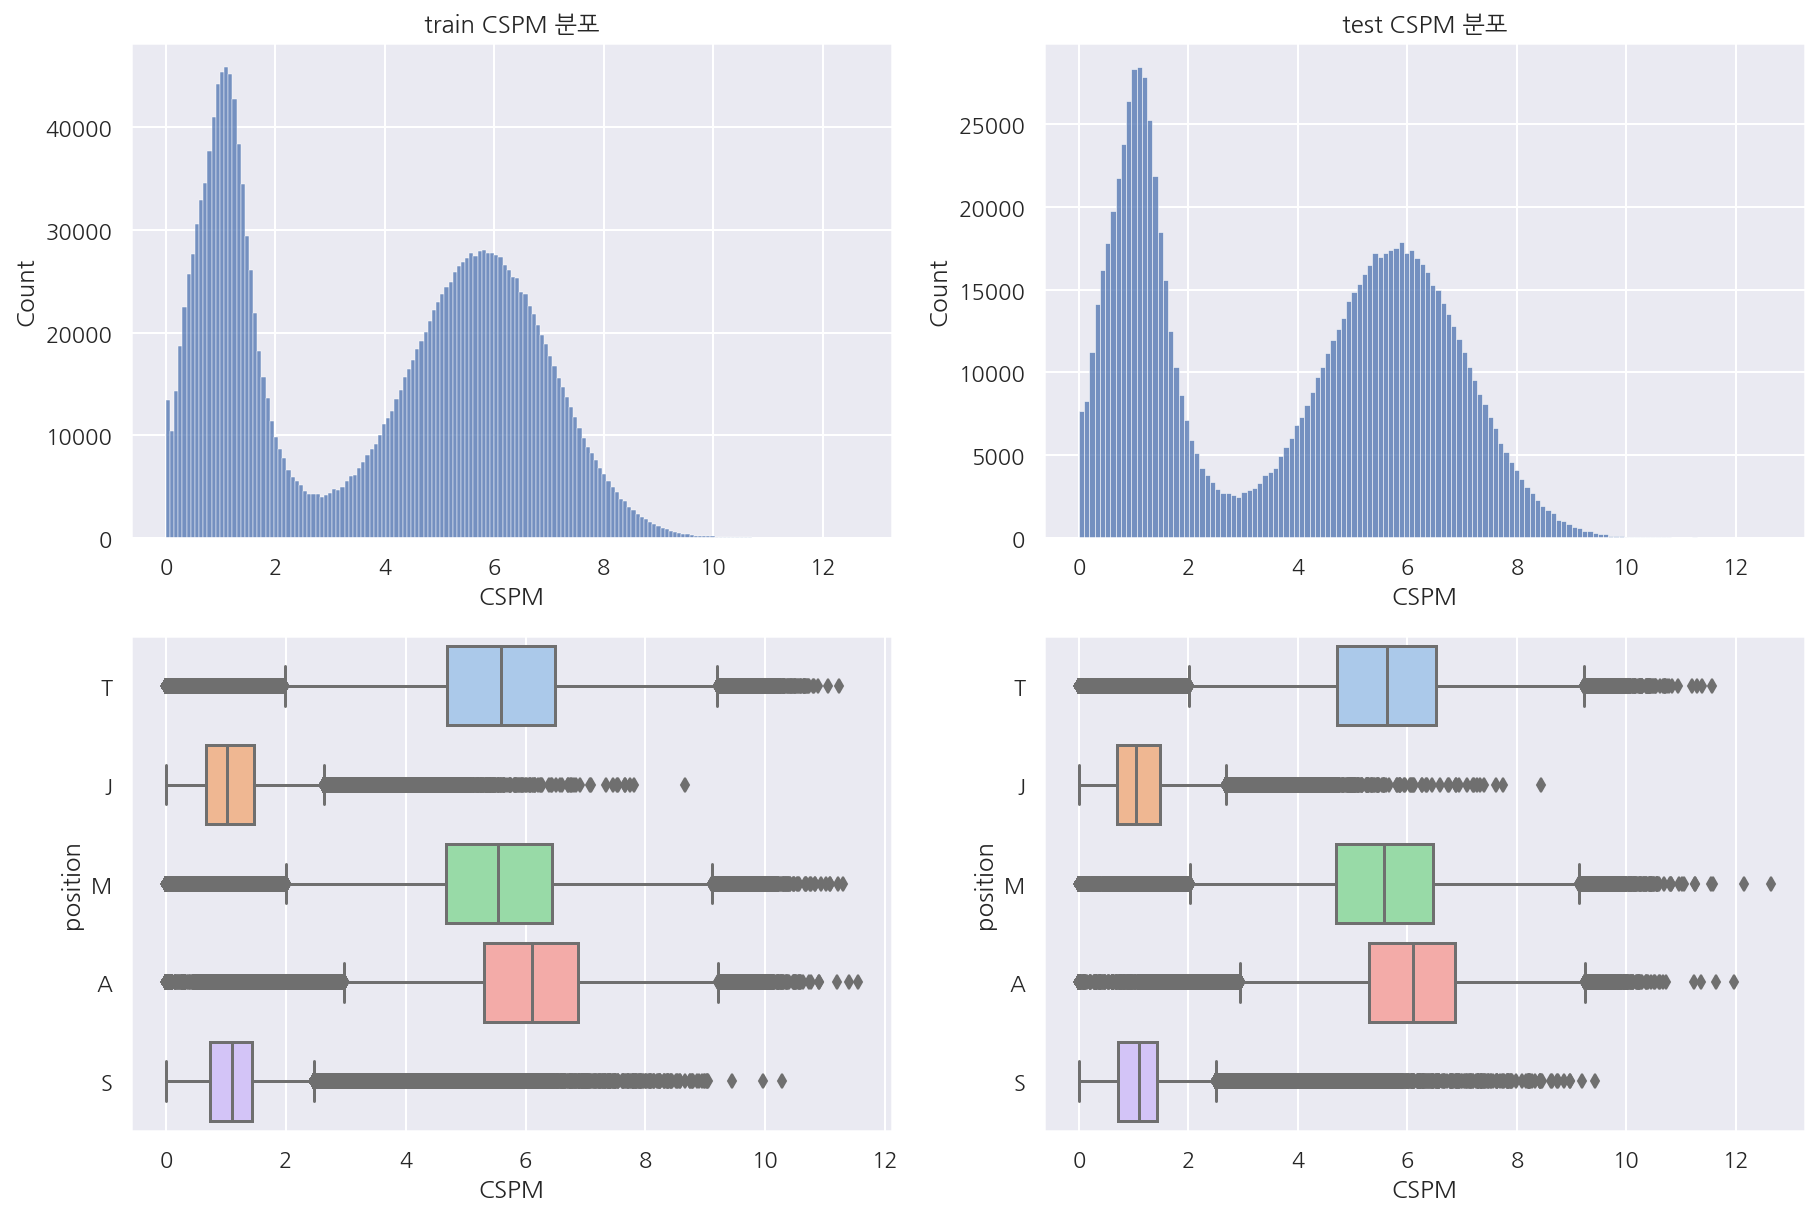

In [22]:
visualization("train", "test", "CSPM")

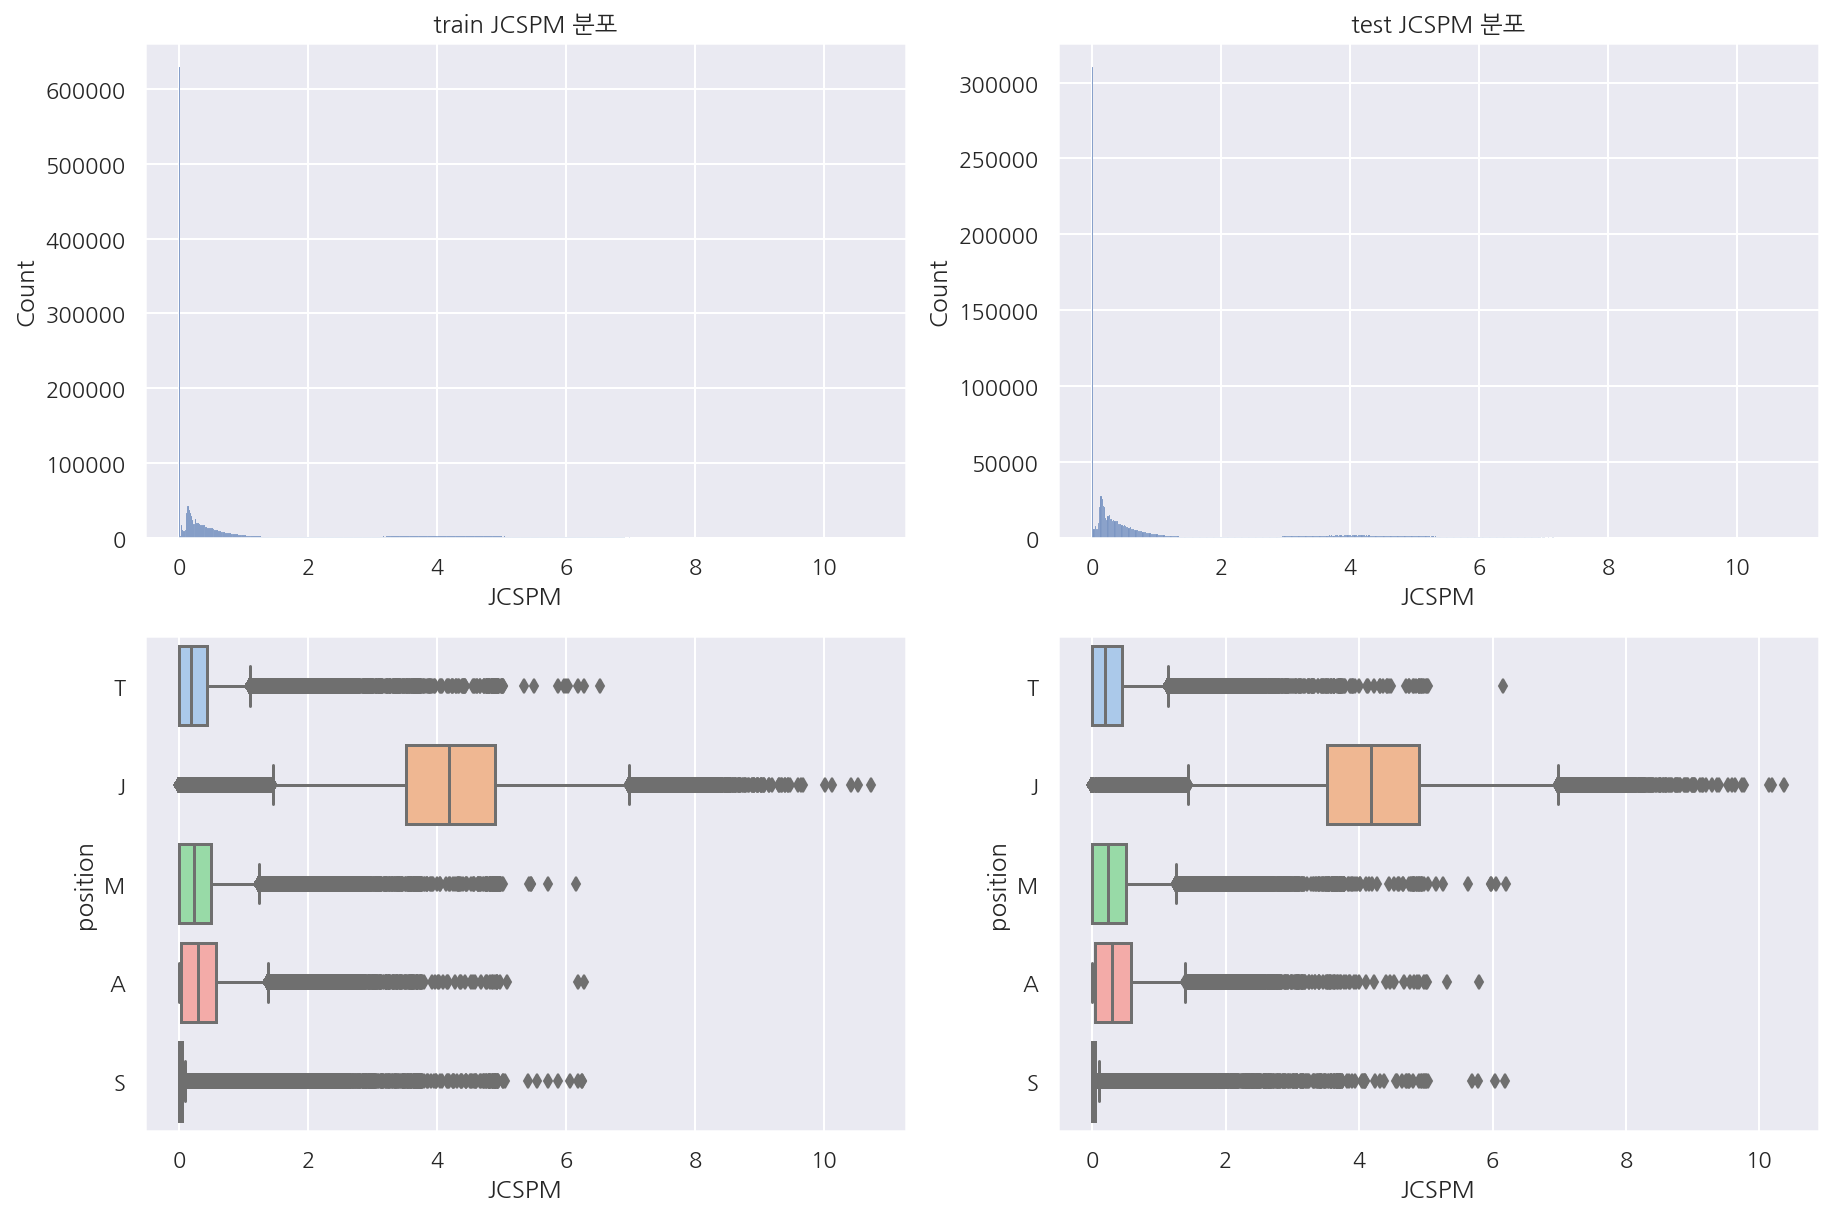

In [23]:
visualization("train", "test", "JCSPM")

In [24]:
temp = train[train["JCSPM"]==0].position.value_counts().reset_index()
temp["position"] = temp["position"] / temp["position"].sum()
temp

,index,position
0,S,0.468252
1,T,0.193506
2,M,0.177749
3,A,0.157756
4,J,0.002737


In [25]:
temp = test[test["JCSPM"]==0].position.value_counts().reset_index()
temp["position"] = temp["position"] / temp["position"].sum()
temp

,index,position
0,S,0.472917
1,T,0.190387
2,M,0.176618
3,A,0.157577
4,J,0.002501


- train, test 모두 분당 정글 CS가 0인 경우의 비율이 포지션별로 비슷하다.

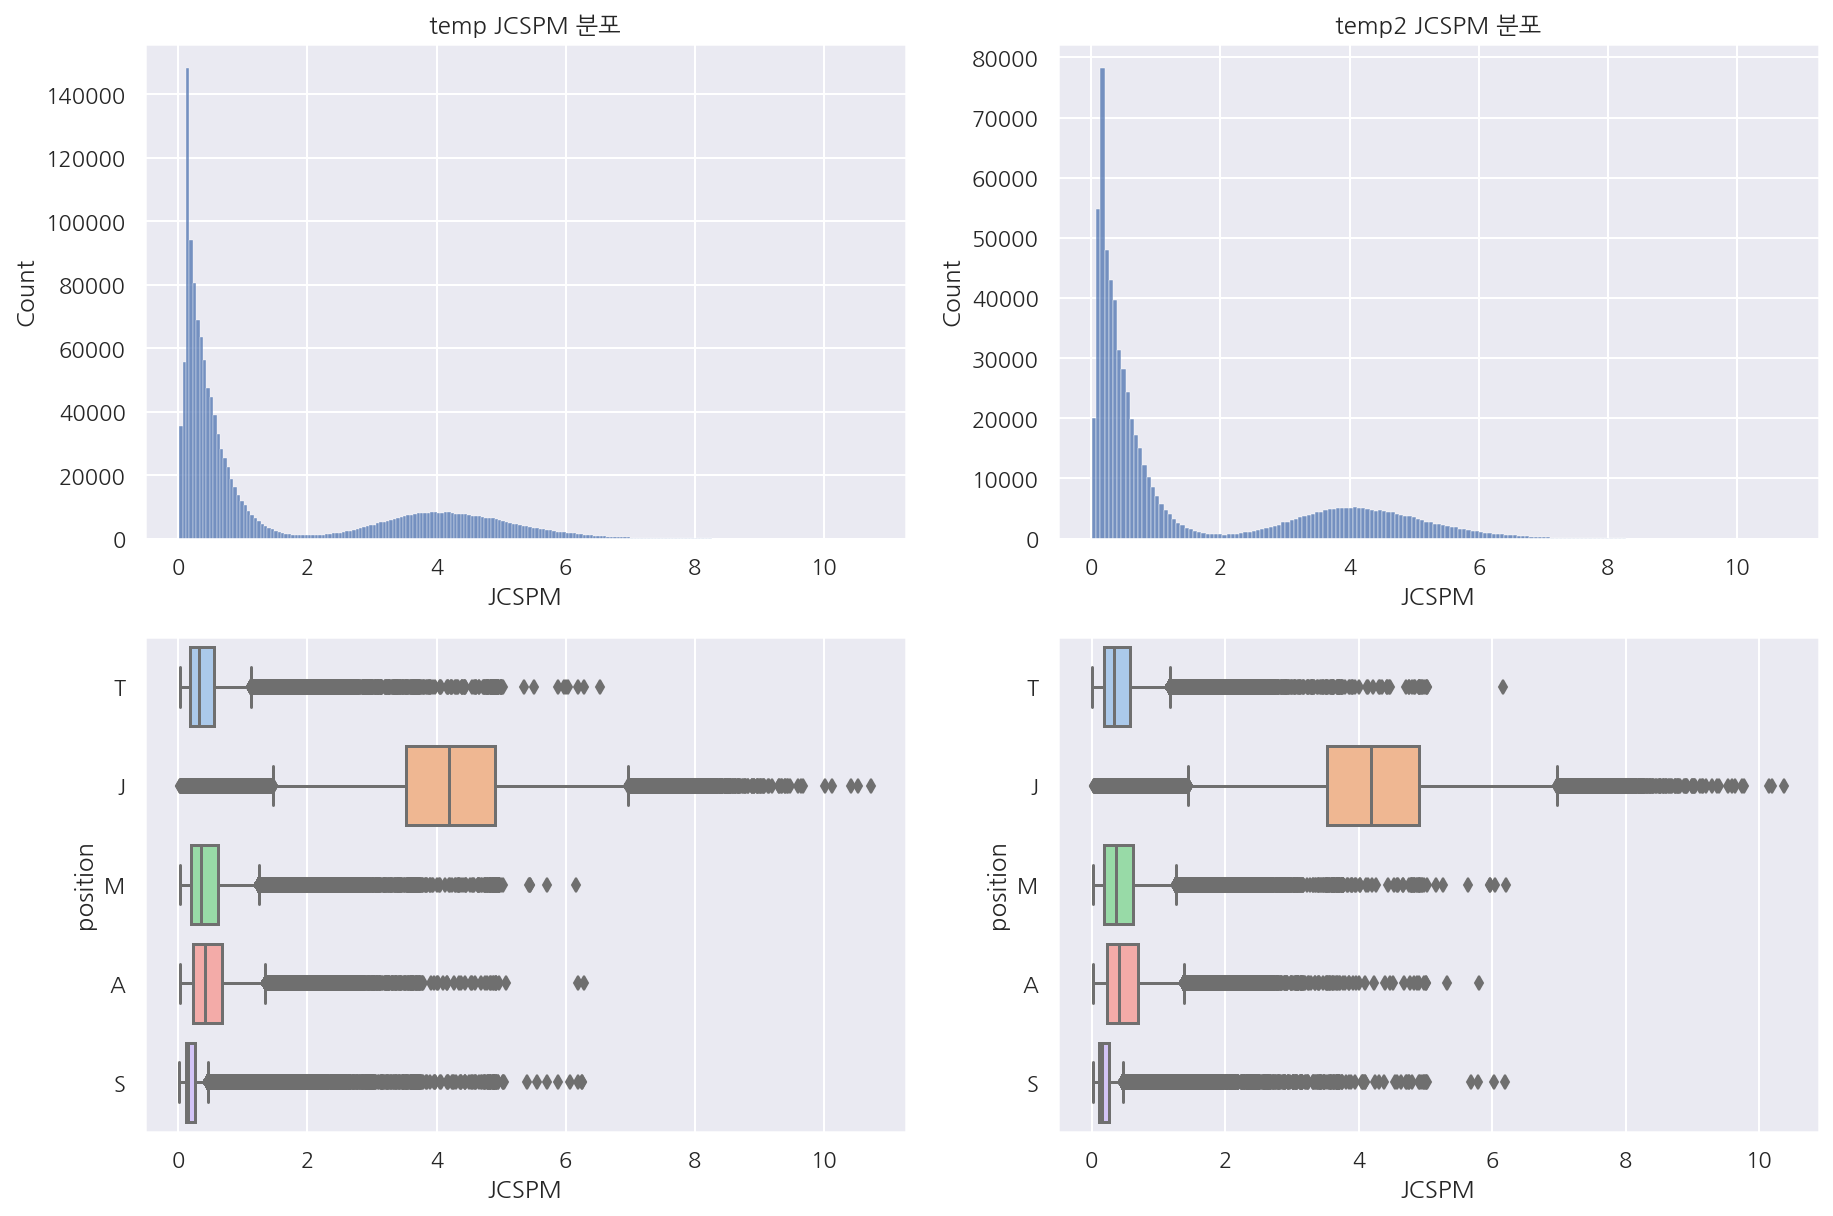

In [26]:
temp = train[train["JCSPM"]!=0]
temp2 = test[test["JCSPM"]!=0]
visualization("temp", "temp2", "JCSPM")

#### 1.4.2 와드

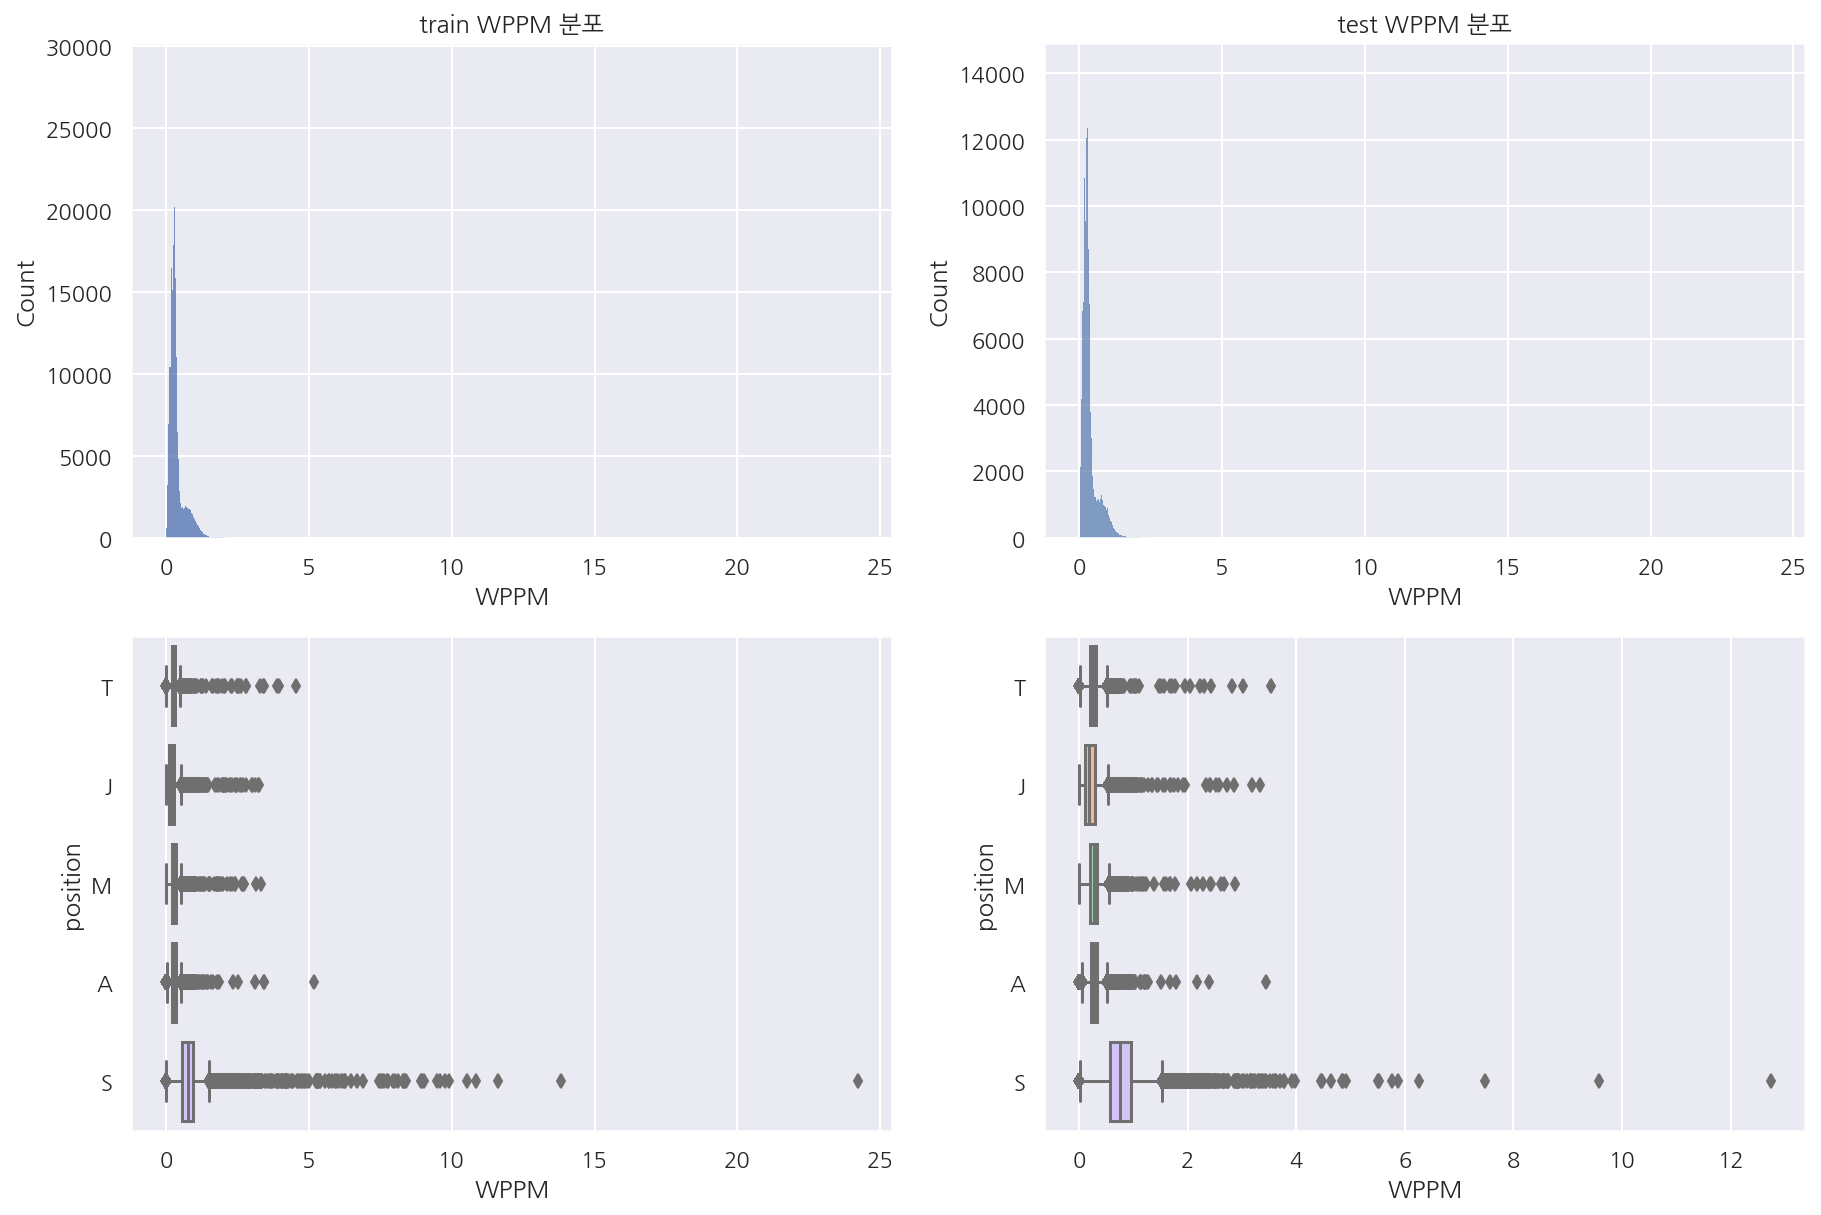

In [27]:
visualization("train", "test", "WPPM")

- 와드 설치의 경우 서폿이 많은 것이 보인다.


- 시야 아이템이 없다면 제어와드는 최대 2개 소지 가능할텐데 이 때 분당 5개가 넘는다면 좀 이상함(제어:2,기본:2)


- 서폿의 경우 시야 아이템 + 제어와드 + (경계의 와드석) 고려하면 6개는 가능하겠지만 템이 나오는 시간 고려


- 템이 나왔더라도 1분마다 설치 귀환 설치 귀환으로 하지 않는다면 무리가 있어보임


- 기본 와드 쿨타임도 고려하면 분당 3~4개가 일반적으로 많이 설치한 게 아닐까 싶기도..(상황 별로 너무 다름)

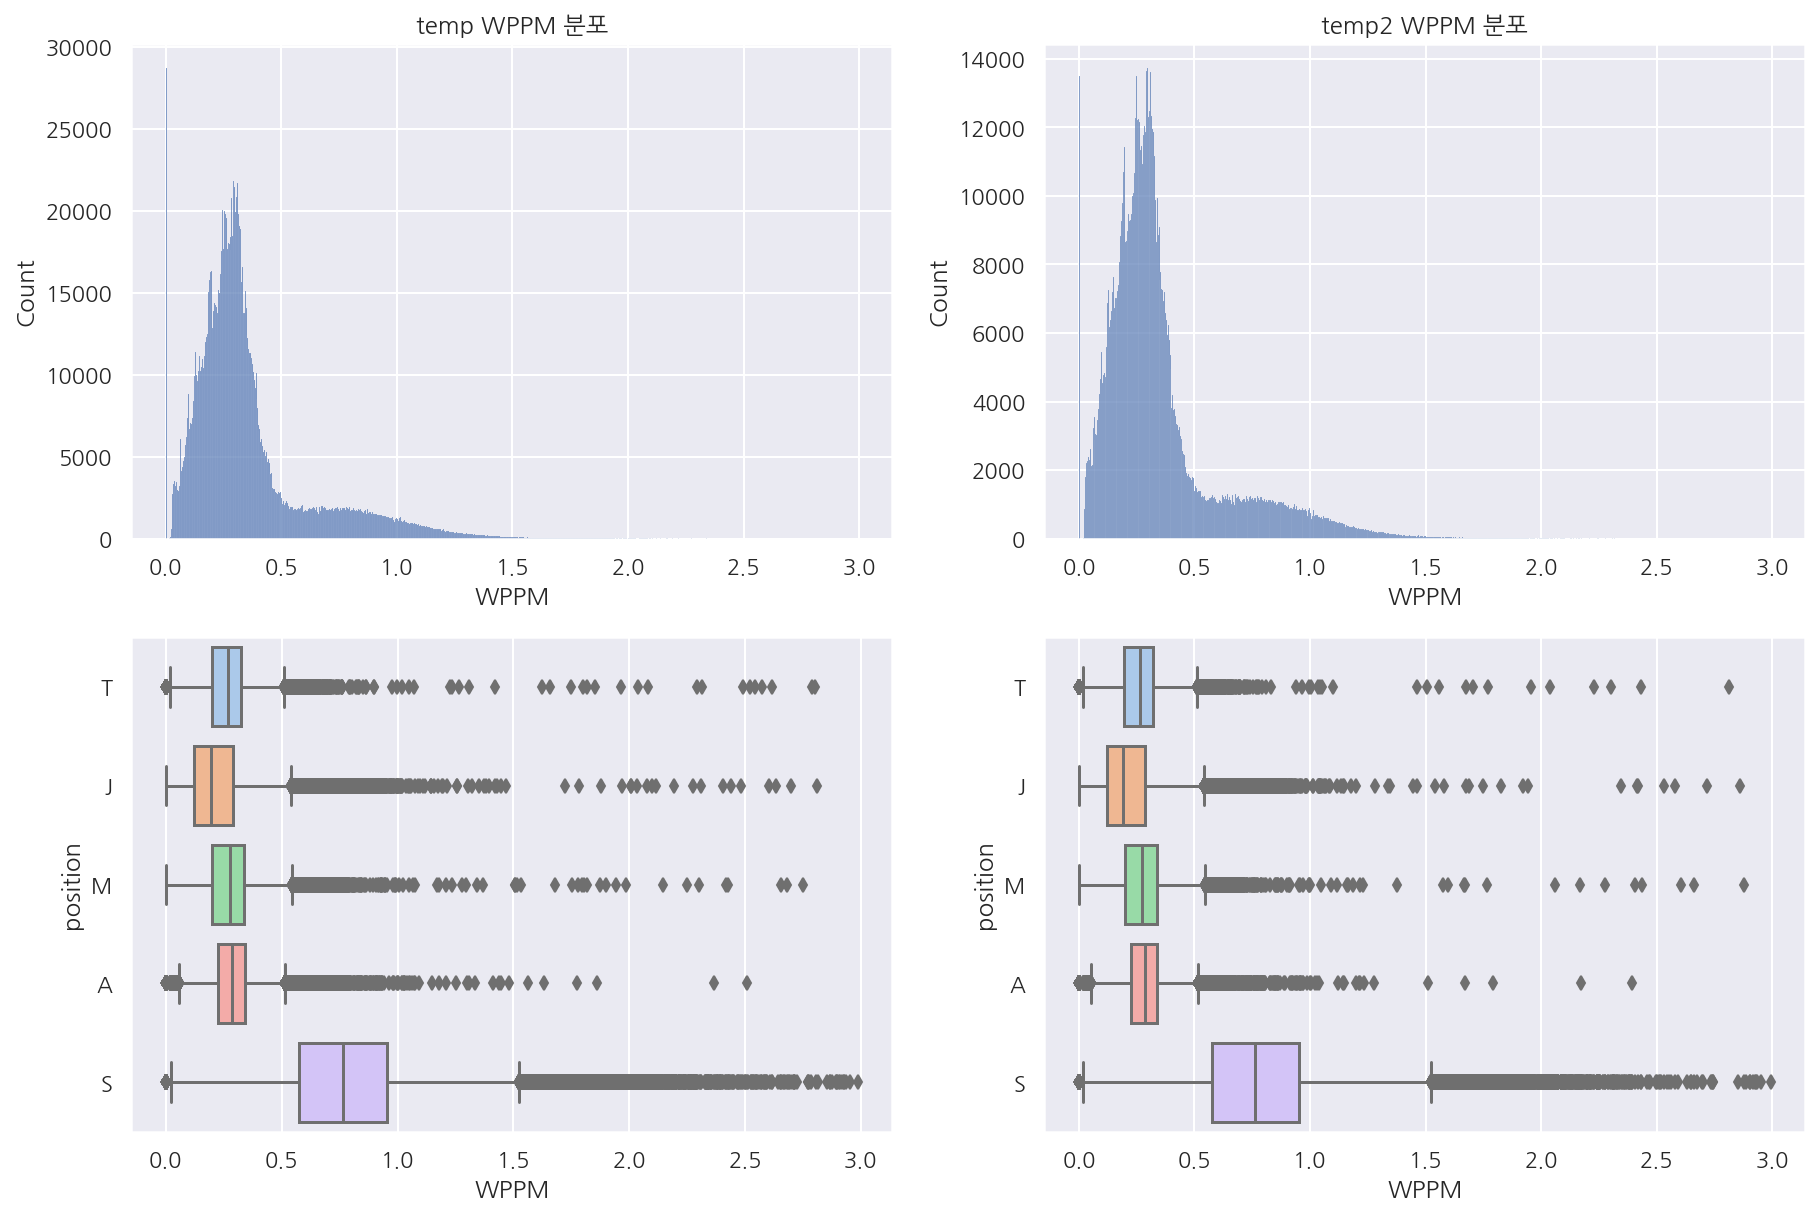

In [28]:
temp = train[train["WPPM"] <= 3]
temp2 = test[test["WPPM"] <= 3]
visualization("temp", "temp2", "WPPM")

- 3개보다 크면 3으로 변환할까?

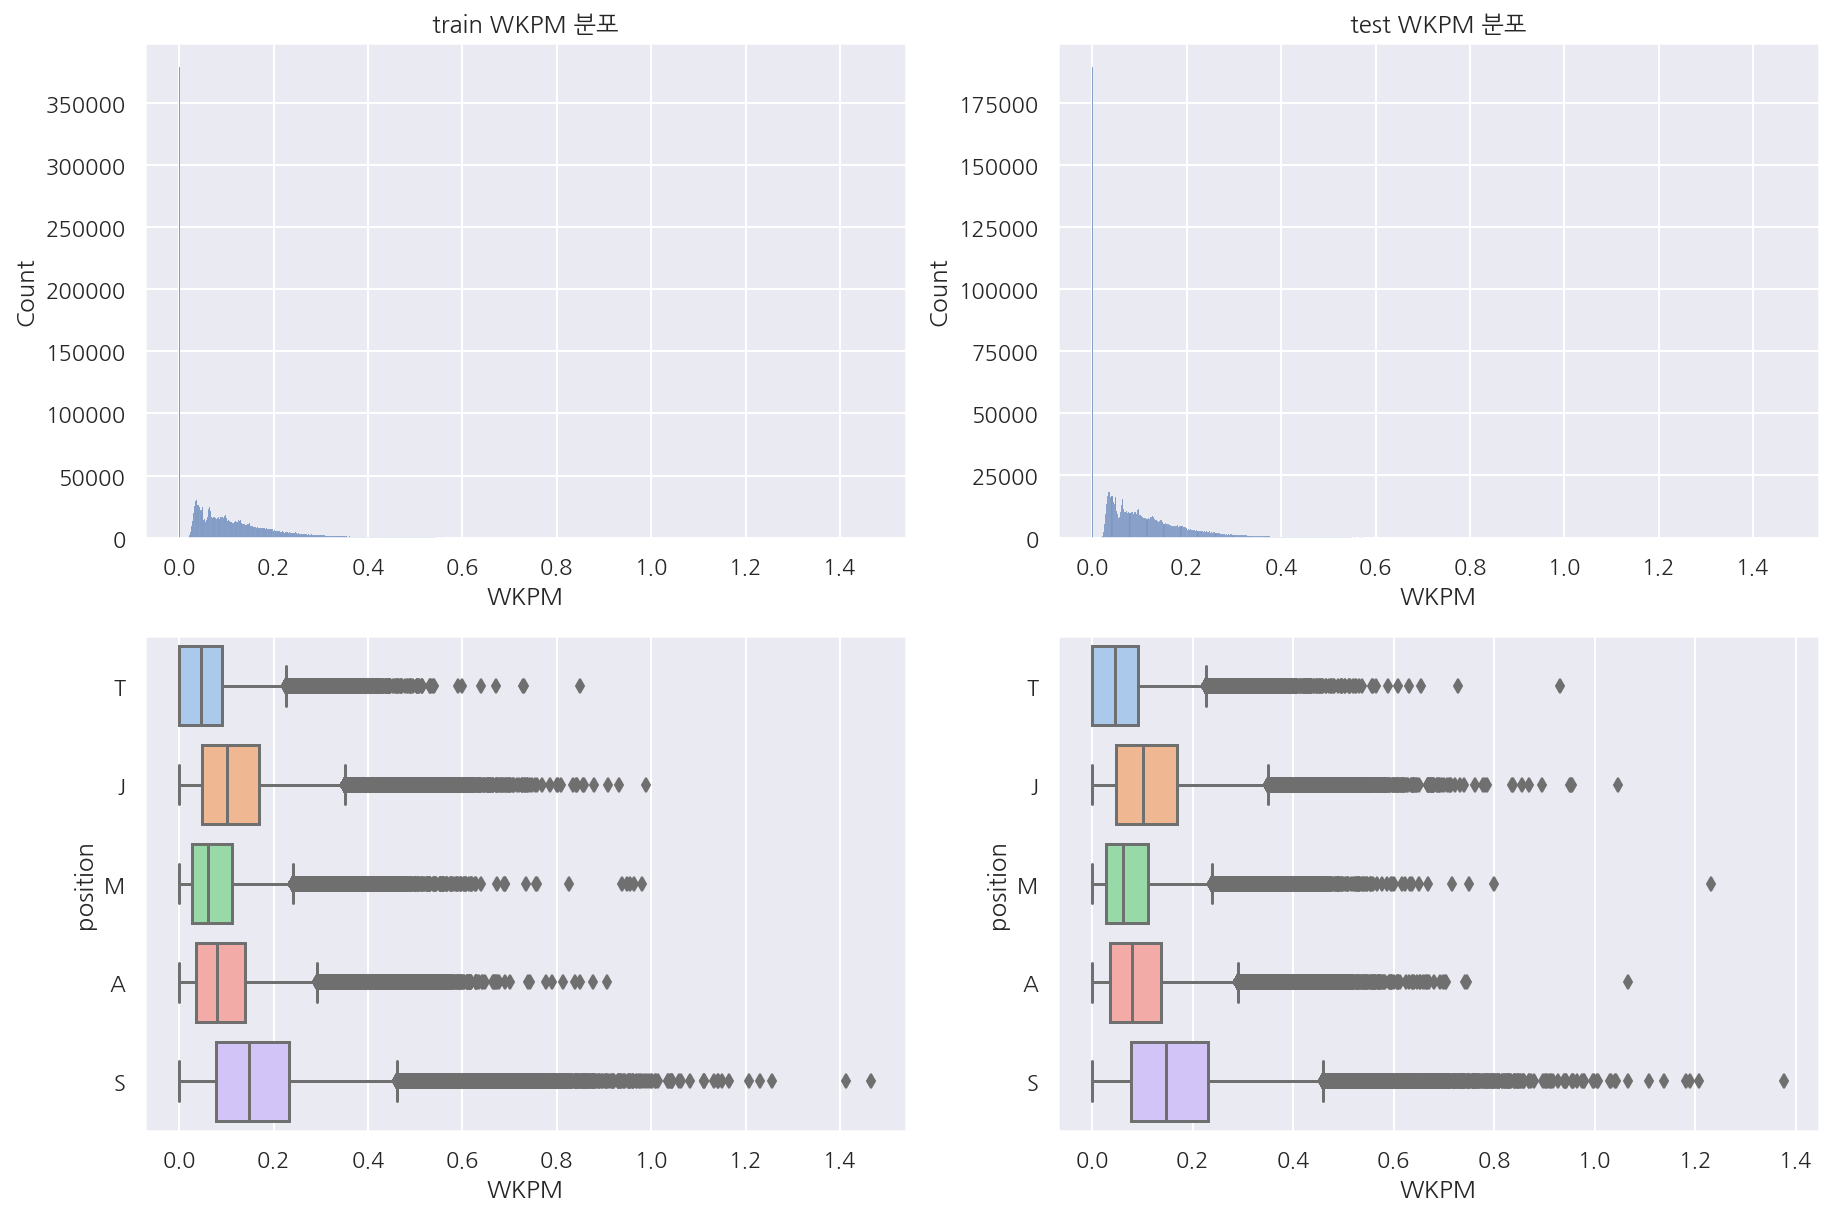

In [29]:
visualization("train", "test", "WKPM")

- 와드 제거 횟수도 서폿이 많긴 한데 확 구분되는 느낌은 아님


- 렌즈 돌렸을때 제거하는 사람이 누구냐에 따라 이 횟수가 추가 되는 것이 아닐까?

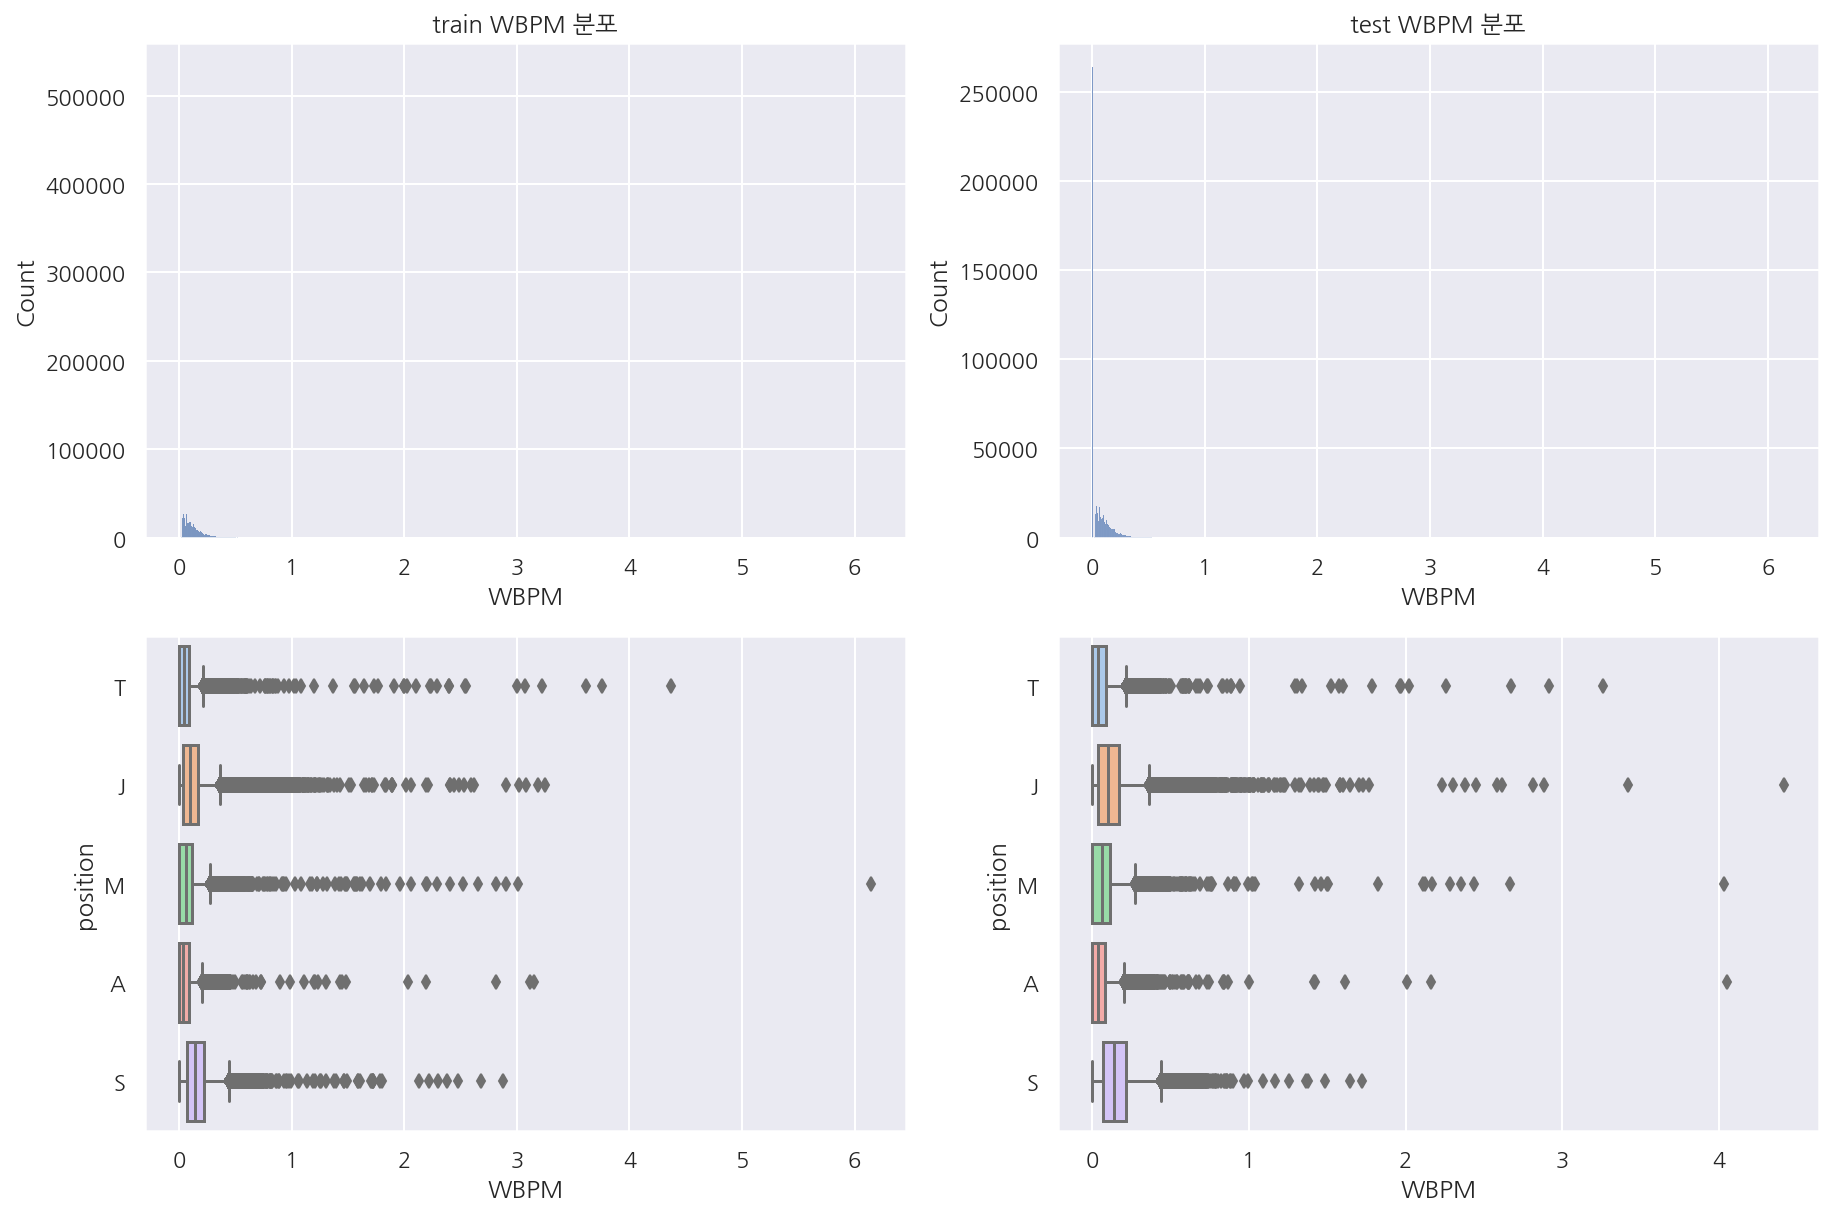

In [30]:
# visualization("train", "test", "visionWardsBoughtInGame")
visualization("train", "test", "WBPM")

- 제어와드 구매 횟수를 분당으로 나타낸 것 흠...


- 이런거 보면 티어별로 구분을 할 필요도 있을 것 같은데..

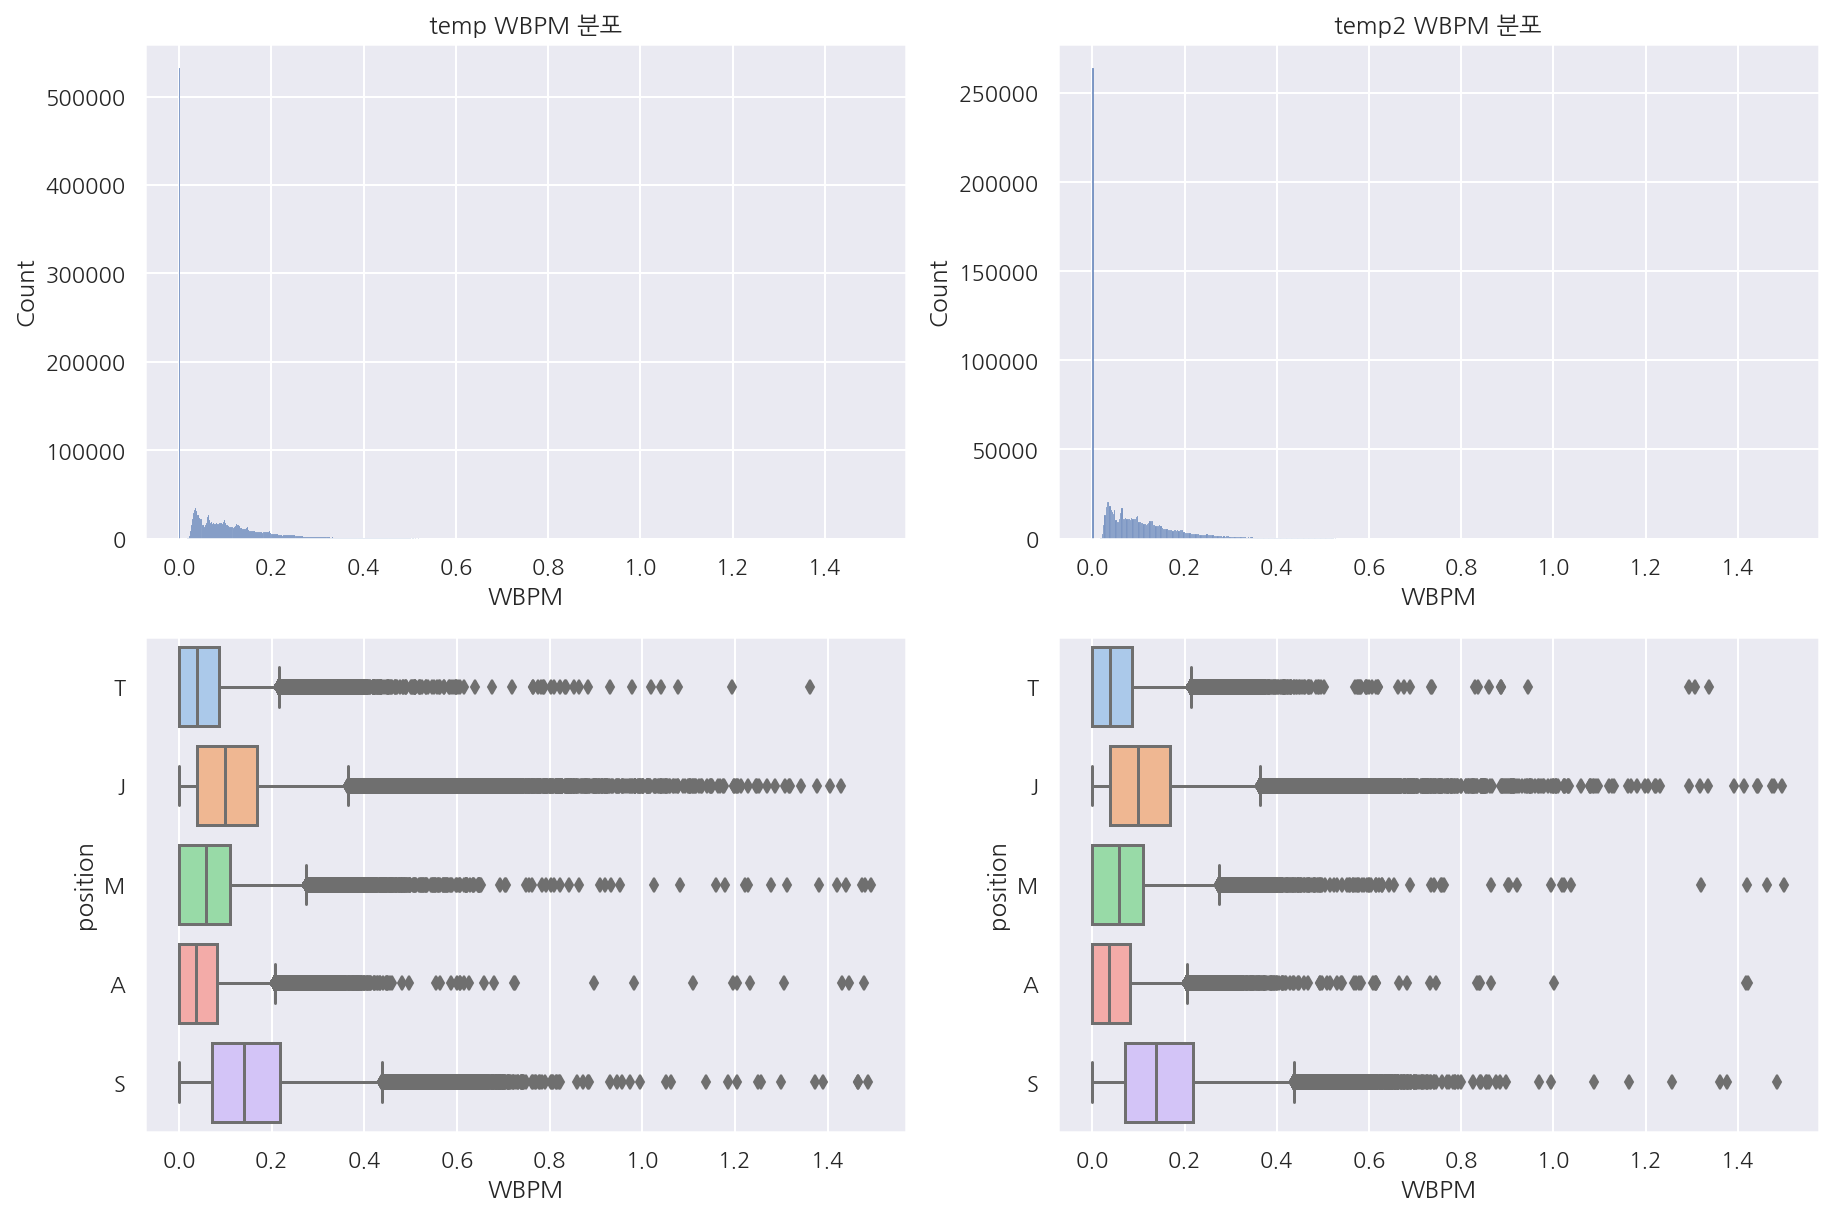

In [31]:
temp = train[train["WBPM"] <= 1.5]
temp2 = test[test["WBPM"] <= 1.5]
visualization("temp", "temp2", "WBPM")

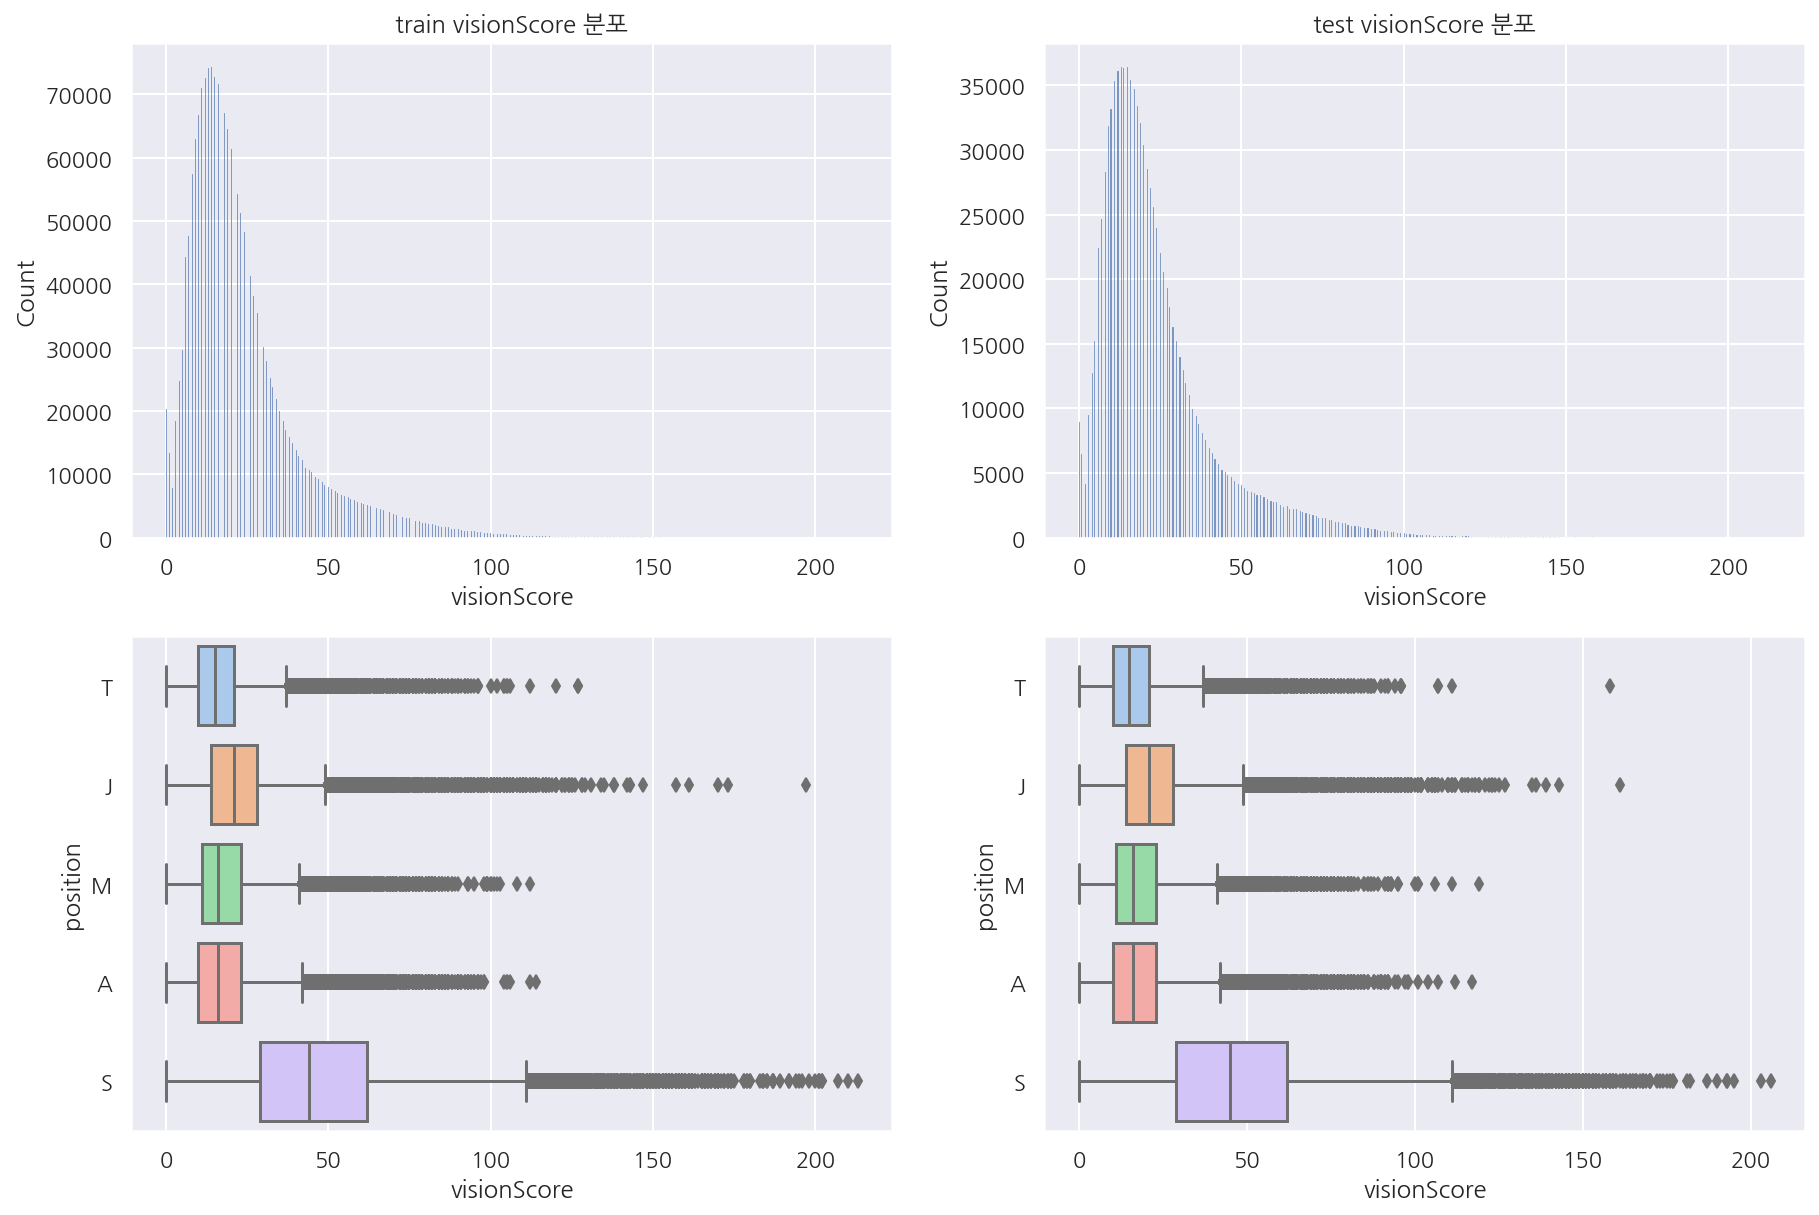

In [32]:
visualization("train", "test", "visionScore")

- 시야 점수도 분 단위로 보는게 맞을까?


- 분 단위로 안하기엔 게임시간에 영향을 받긴 함 (다만 어처피 위 요소들이랑 비슷하긴 할듯)

#### 1.4.3 KDA

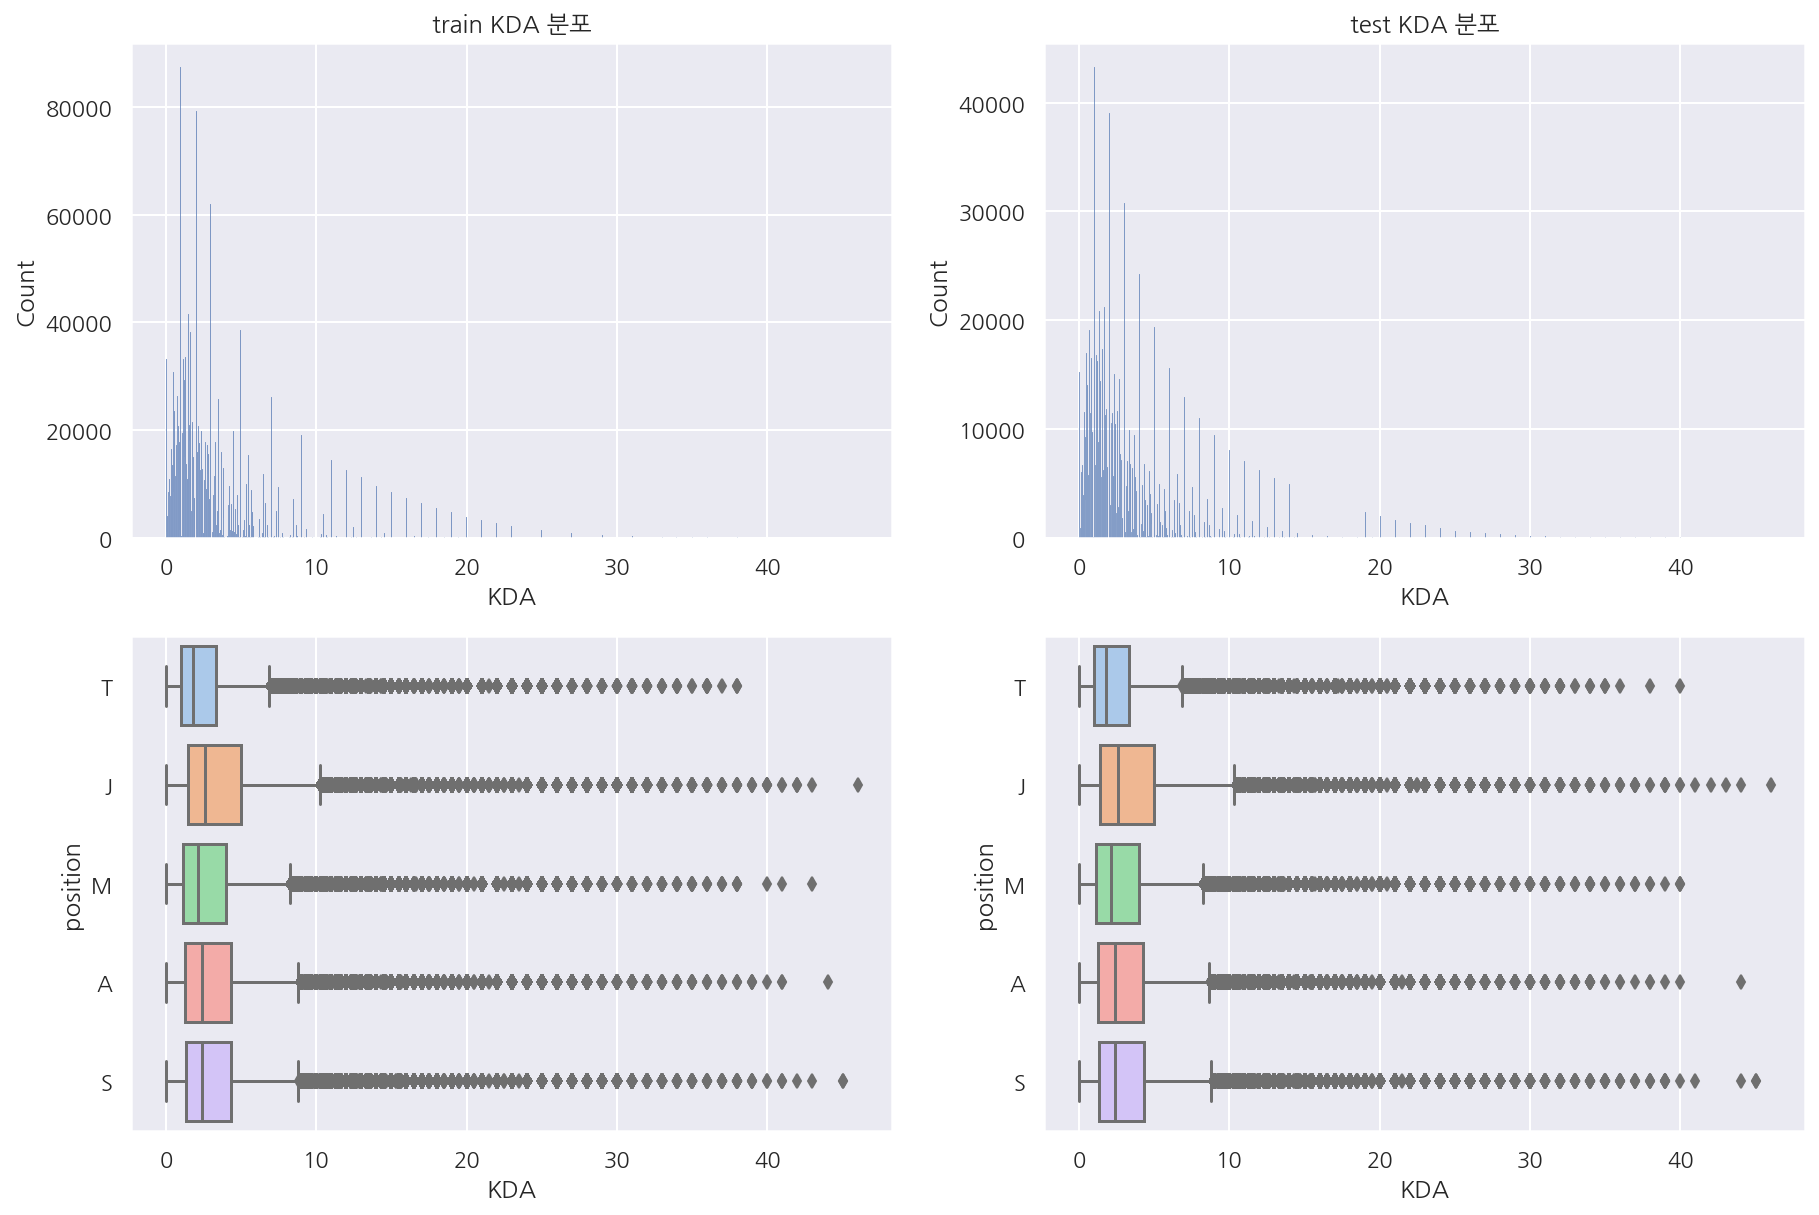

In [33]:
visualization("train", "test", "KDA")

- 예상한대로 KDA는 딱히 포지션 구분이 되는 변수는 아닌 듯 하다.

#### 1.4.4 스펠

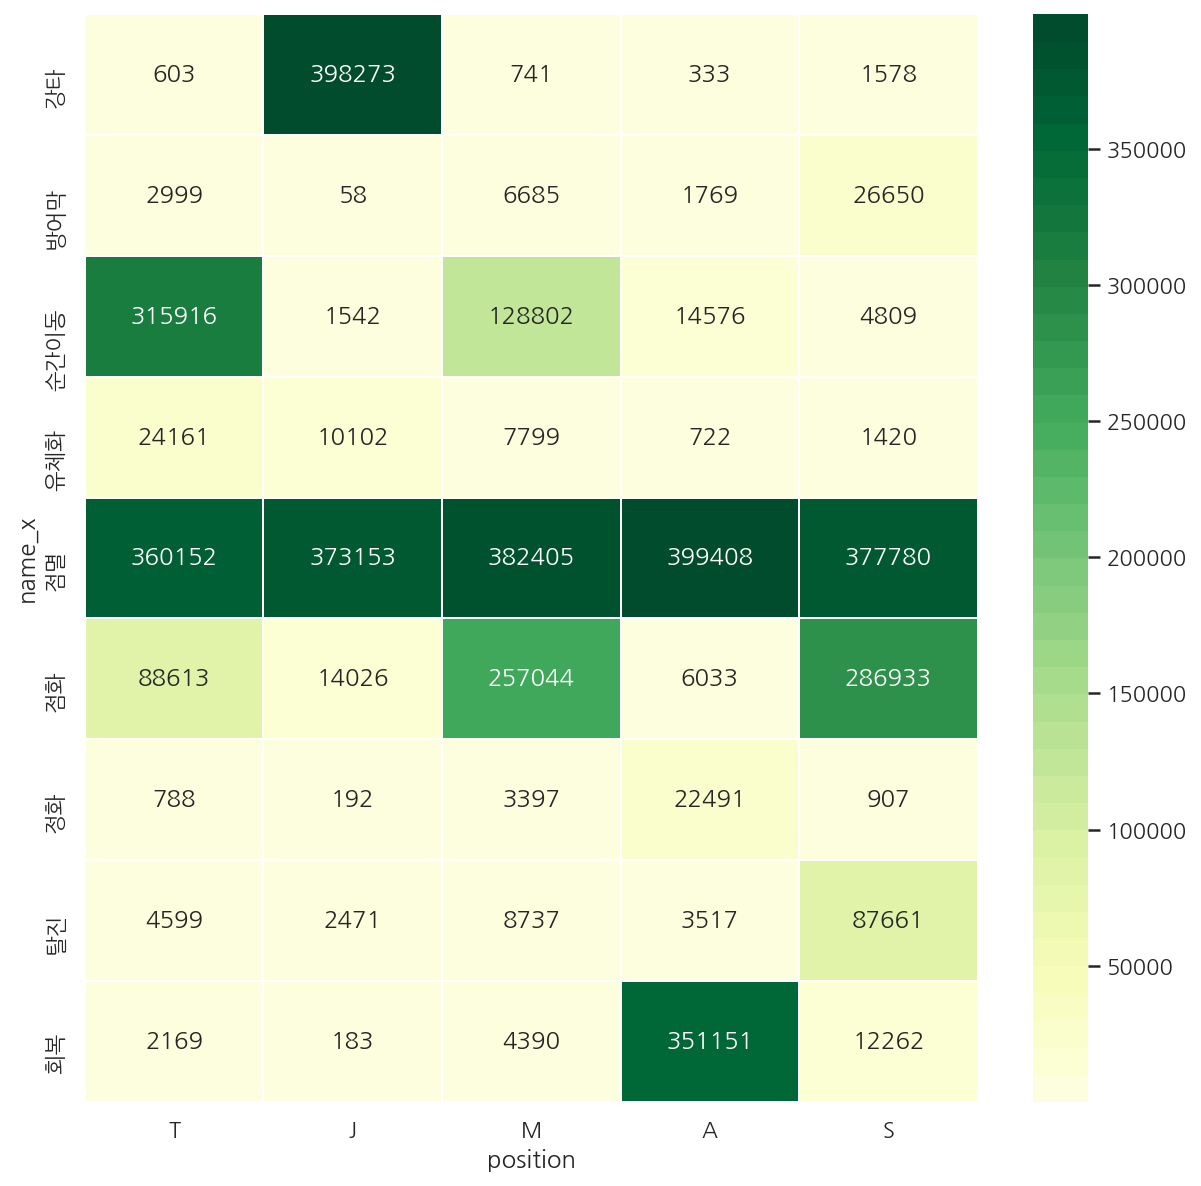

In [34]:
# train 스펠
temp = train[["position","spell1","spell2"]]
temp = pd.merge(temp, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
temp = pd.merge(temp, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
temp2 = temp.groupby(["position","name_x"]).size().unstack("name_x")
temp3 = temp.groupby(["position","name_y"]).size().unstack("name_y")
temp4 = temp2 + temp3

fig, axs = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(temp4.T, fmt="d", cmap=sns.color_palette("YlGn", 40),linewidths=0.5, annot=True)
plt.show()

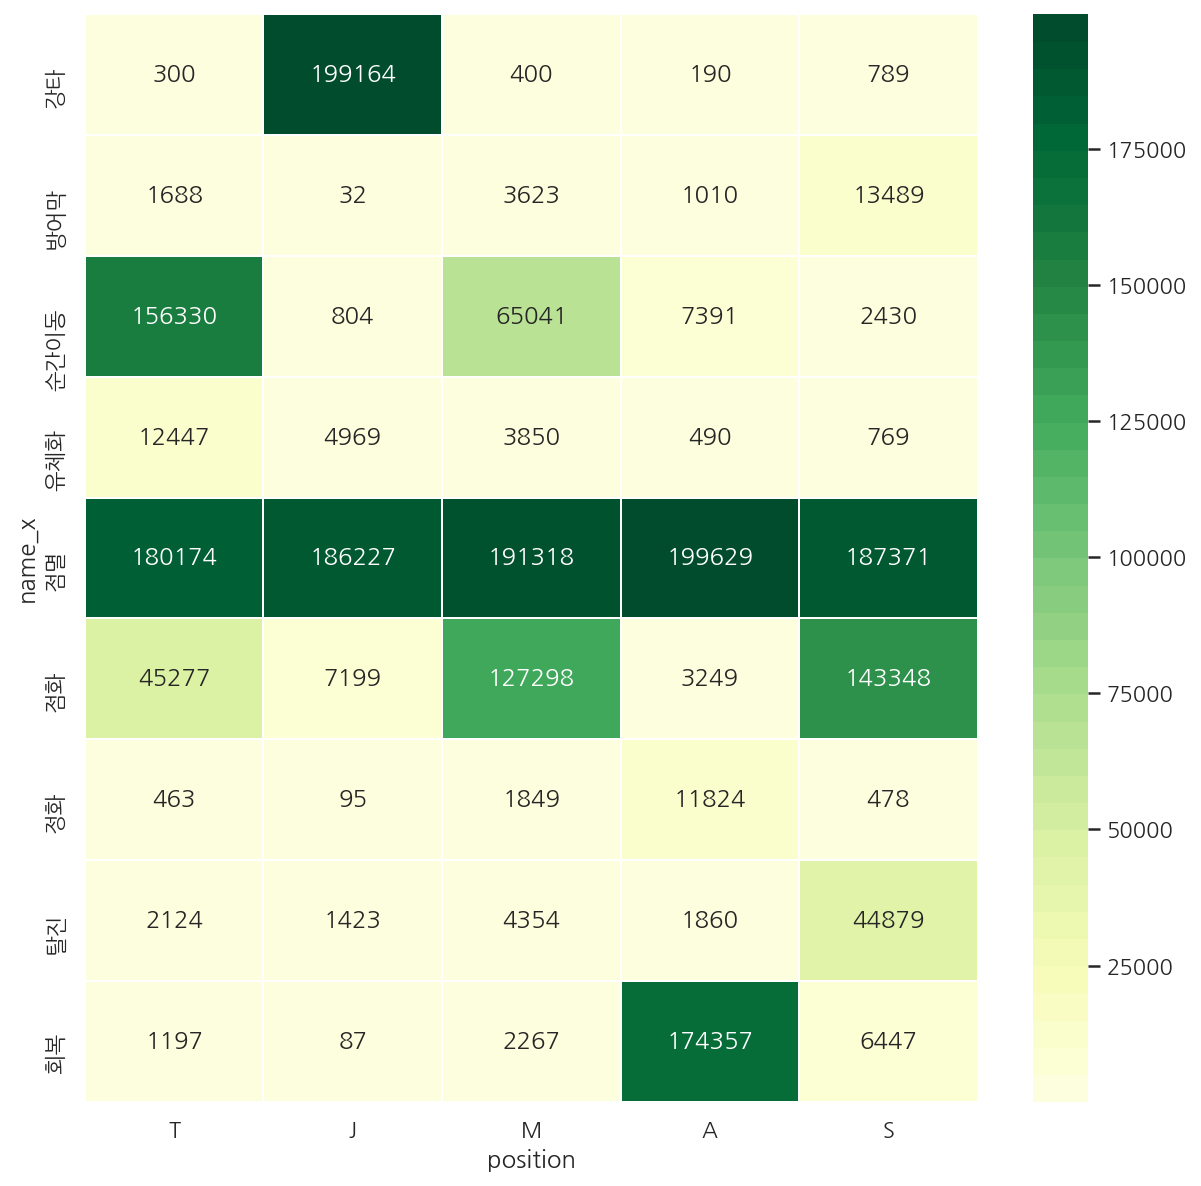

In [35]:
# test 스펠
temp = test[["position","spell1","spell2"]]
temp = pd.merge(temp, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
temp = pd.merge(temp, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
temp2 = temp.groupby(["position","name_x"]).size().unstack("name_x")
temp3 = temp.groupby(["position","name_y"]).size().unstack("name_y")
temp4 = temp2 + temp3

fig, axs = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(temp4.T, fmt="d", cmap=sns.color_palette("YlGn", 40),linewidths=0.5, annot=True)
plt.show()

In [36]:
# 스펠 순서 함수 (점멸/점화, 점화/점멸 똑같으므로)
def spell_order(x):
    if x["spell1"] < x["spell2"]:
        result = x["name_x"] + "/" + x["name_y"]
    else:
        result = x["name_y"] + "/" + x["name_x"]
    
    return result

def spell_heatmap(df, rate=False):
    # 스펠 조합 만들기 (순서는 key값이 작은게 앞으로)
    temp = df[["position","spell1","spell2"]]
    temp = pd.merge(temp, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
    temp = pd.merge(temp, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
    temp["comb"] = temp.apply(lambda x: spell_order(x), axis=1)

    # 포지션(row), 스펠 조합(col) 별 카운트 집계
    temp2 = temp.groupby(["position","comb"]).size().unstack("comb").T
           
    # 히트맵 그리기
    fig, axs = plt.subplots(1,1, figsize=(20,20))
    
    # 비율 혹은 카운트로 확인
    if rate == True:
        for col in temp2.columns:
            temp2[col] = np.round(temp2[col] / temp2[col].sum(), 2)
        sns.heatmap(temp2, fmt='.2f', linewidths=0.5, cmap=sns.color_palette("YlGn", 10), annot=True)
    else:
        sns.heatmap(temp2, fmt="d", linewidths=0.5, cmap=sns.color_palette("YlGn", 40), annot=True)
    
    return plt.show()

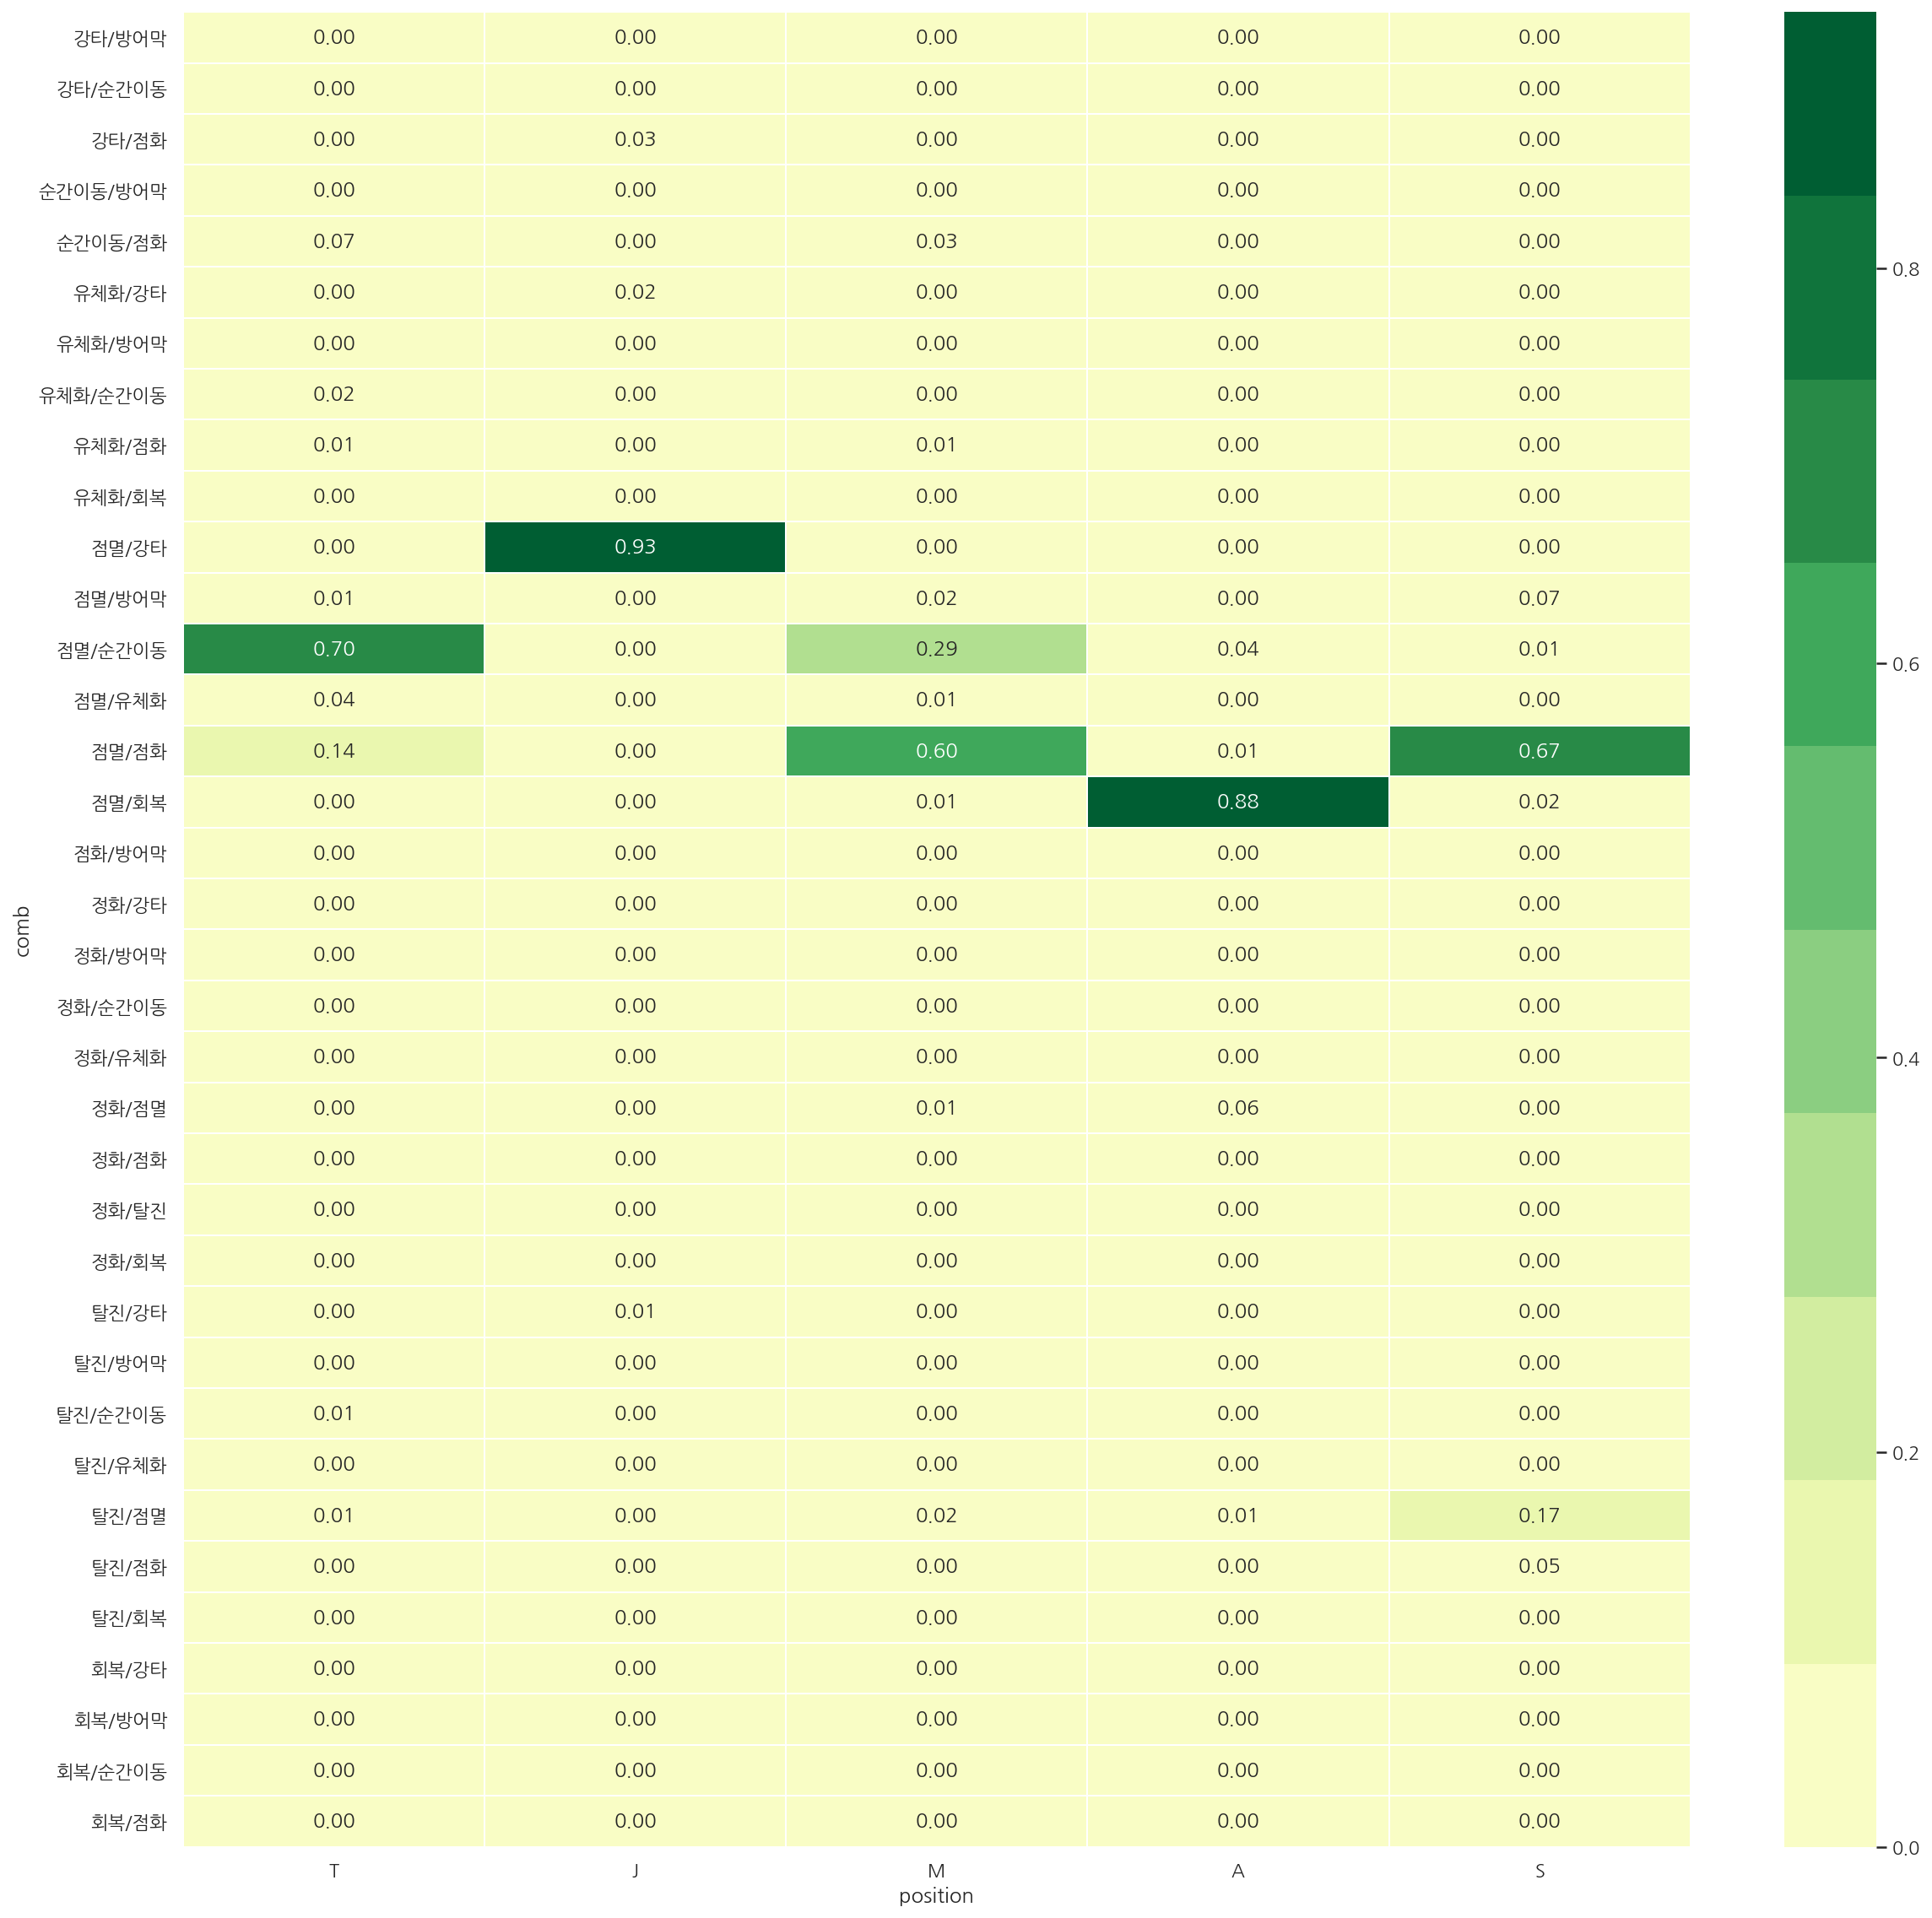

In [37]:
spell_heatmap(train, rate=True)

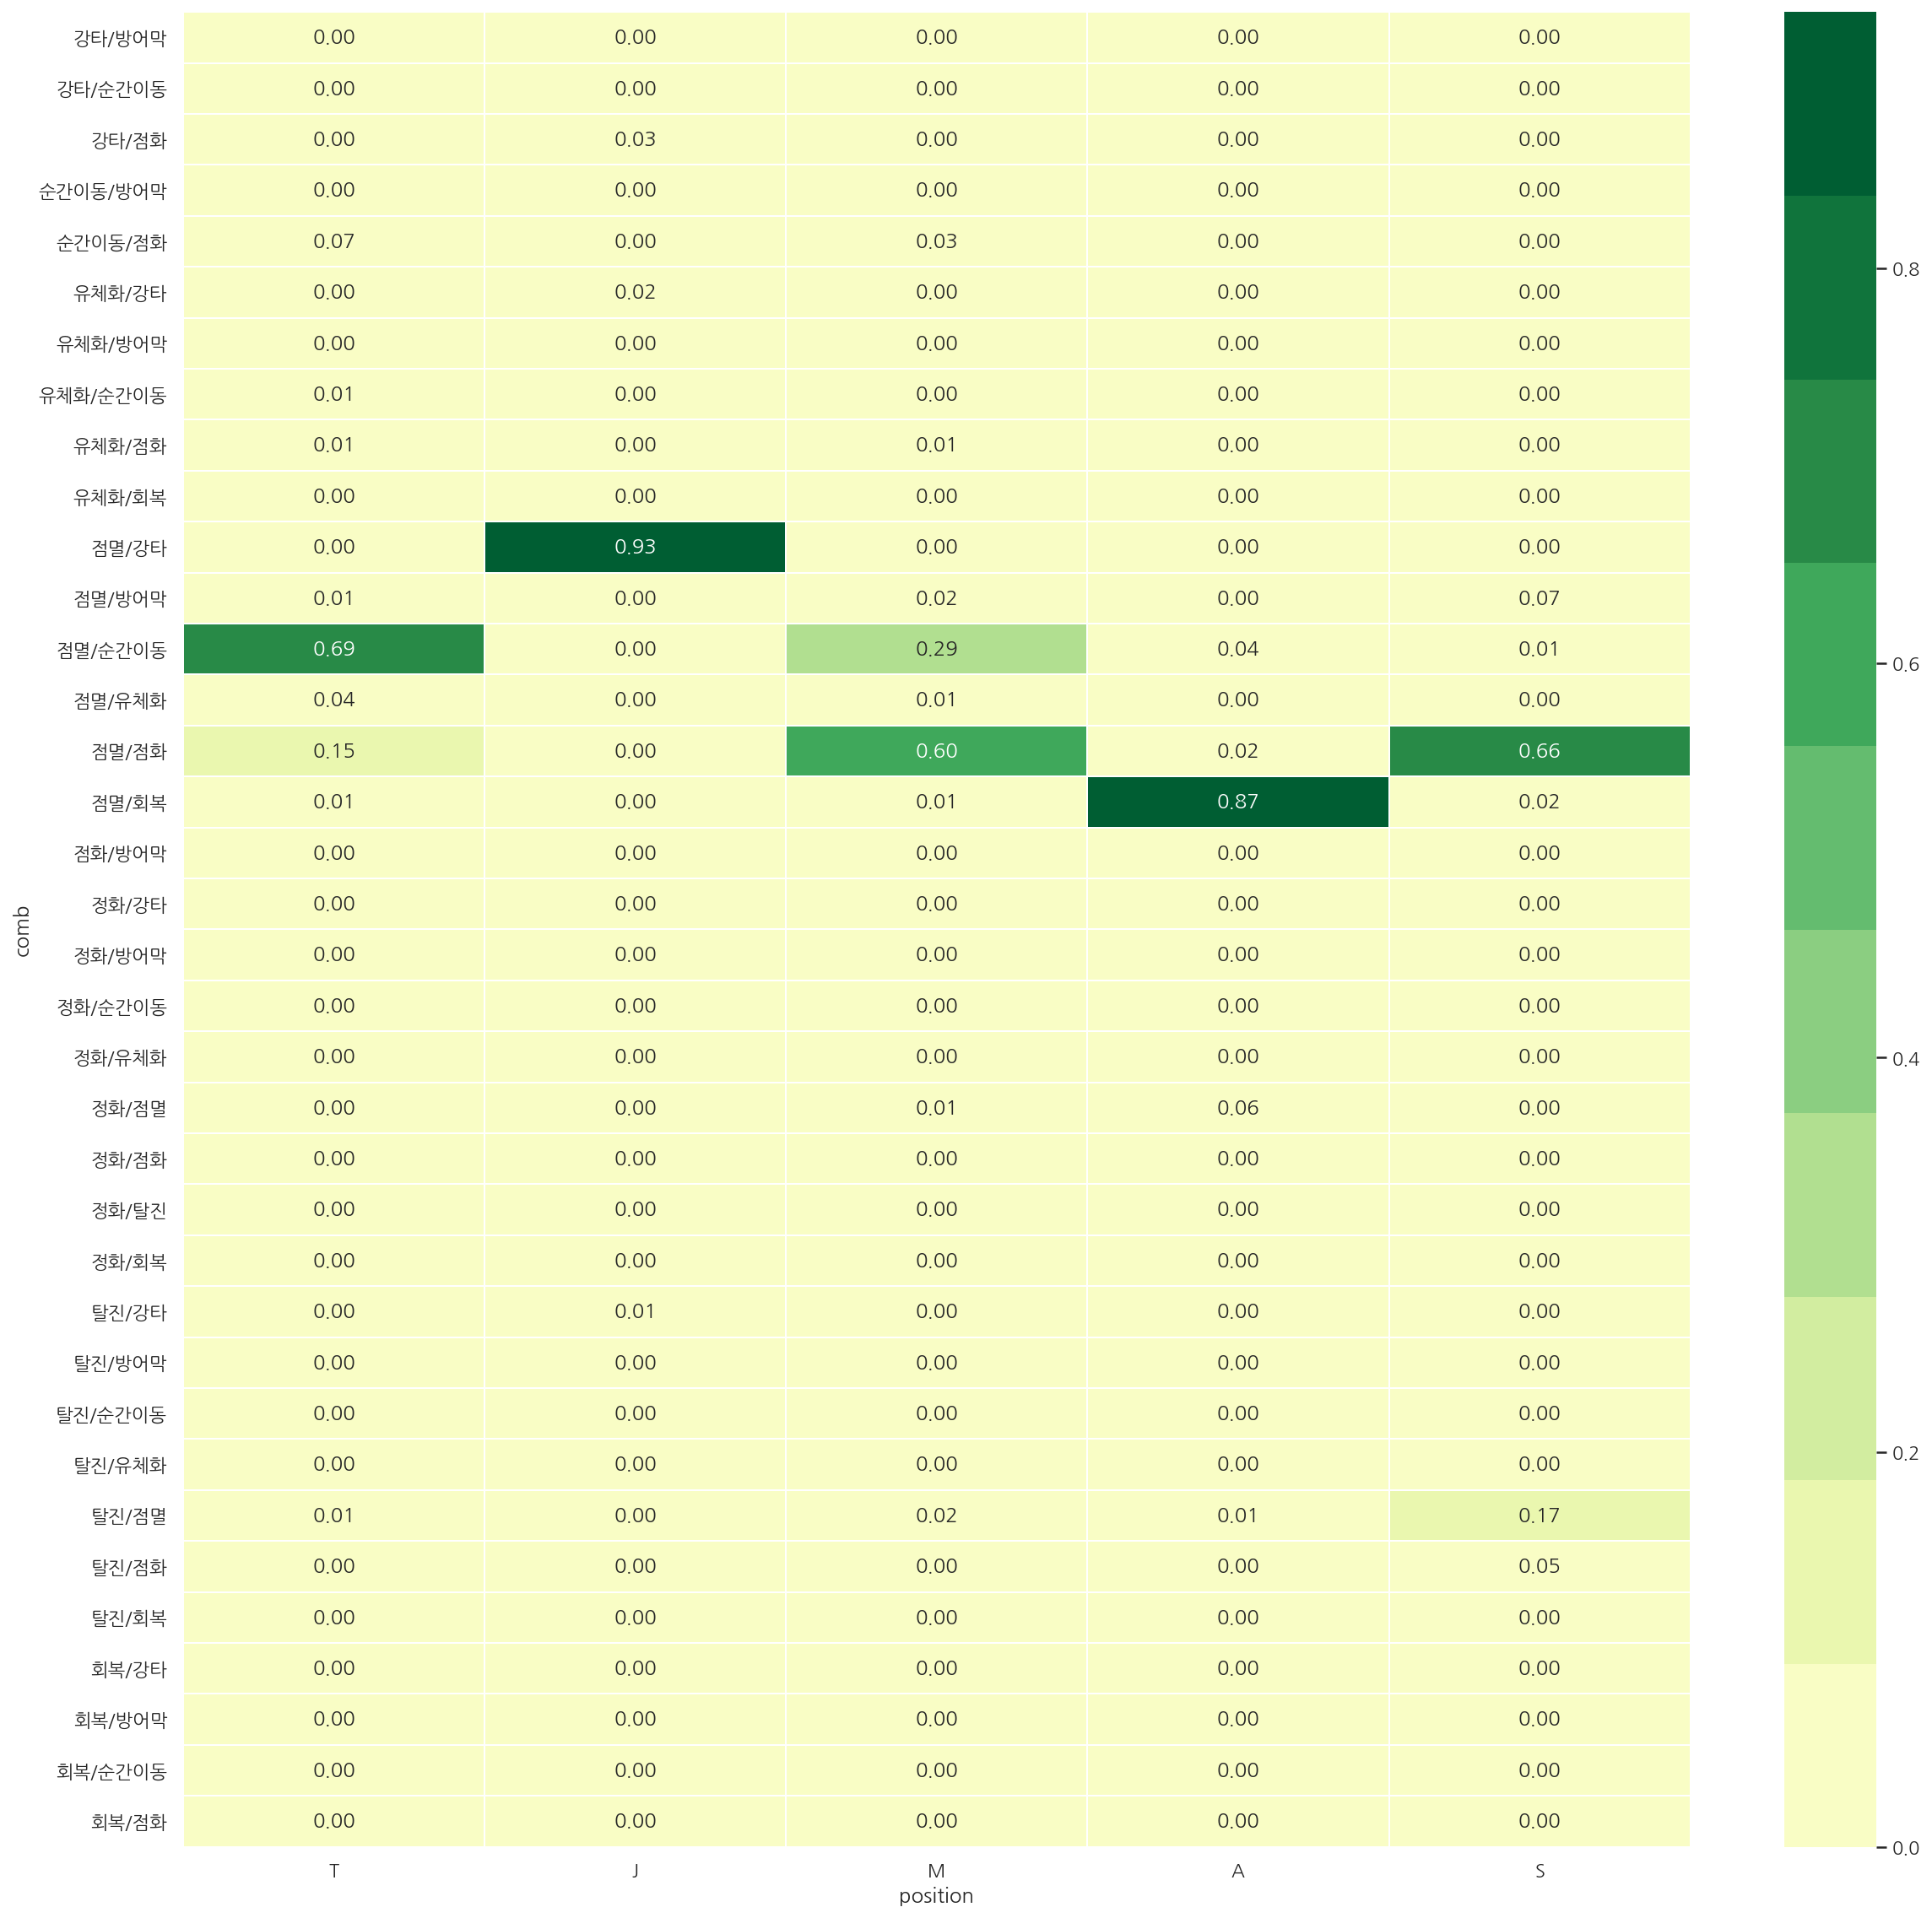

In [38]:
spell_heatmap(test, rate=True)

- train, test 전반적으로 비율은 비슷하고 원딜은 힐을 많이 드는 것이 보임(정화도)

#### 1.4.5 골드 획득

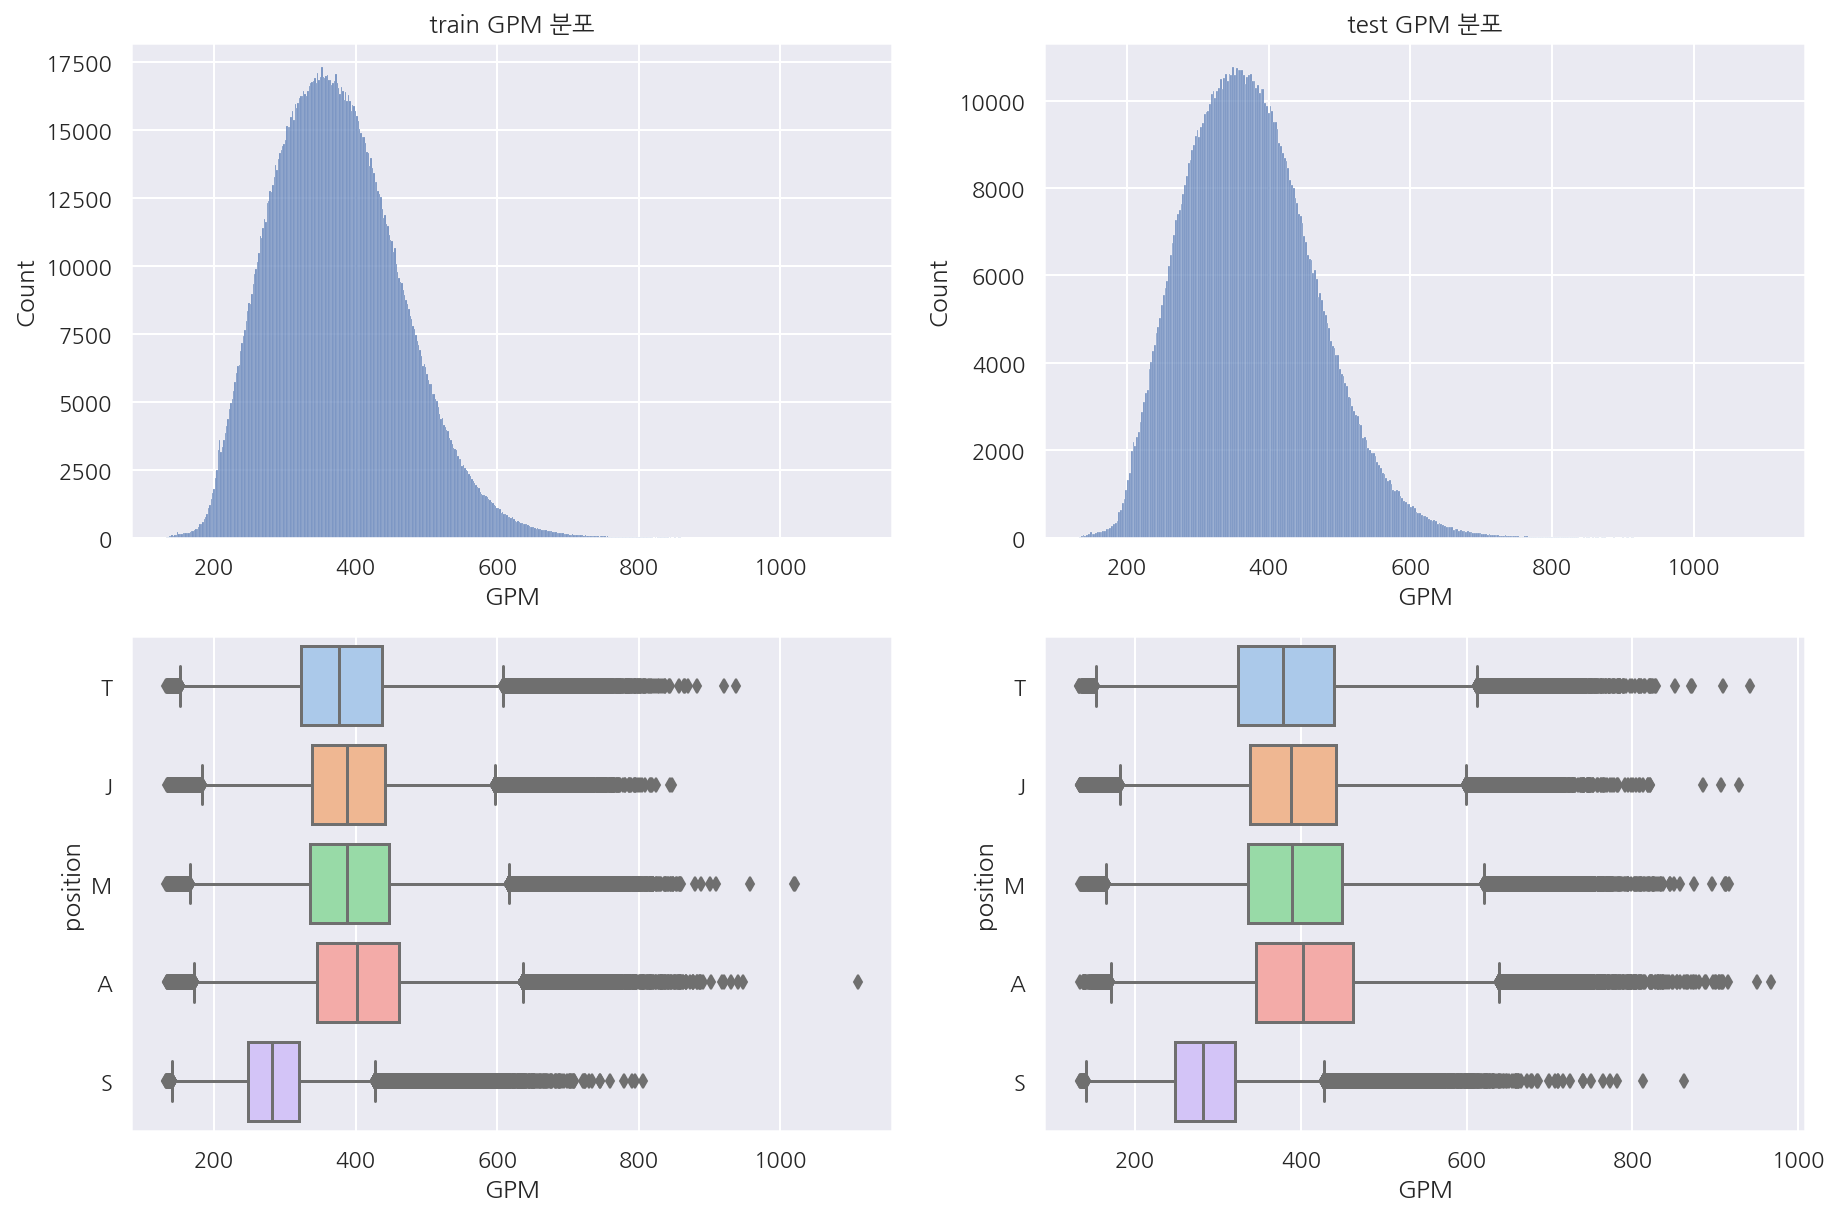

In [39]:
visualization("train", "test", "GPM")

#### 1.4.6 데미지

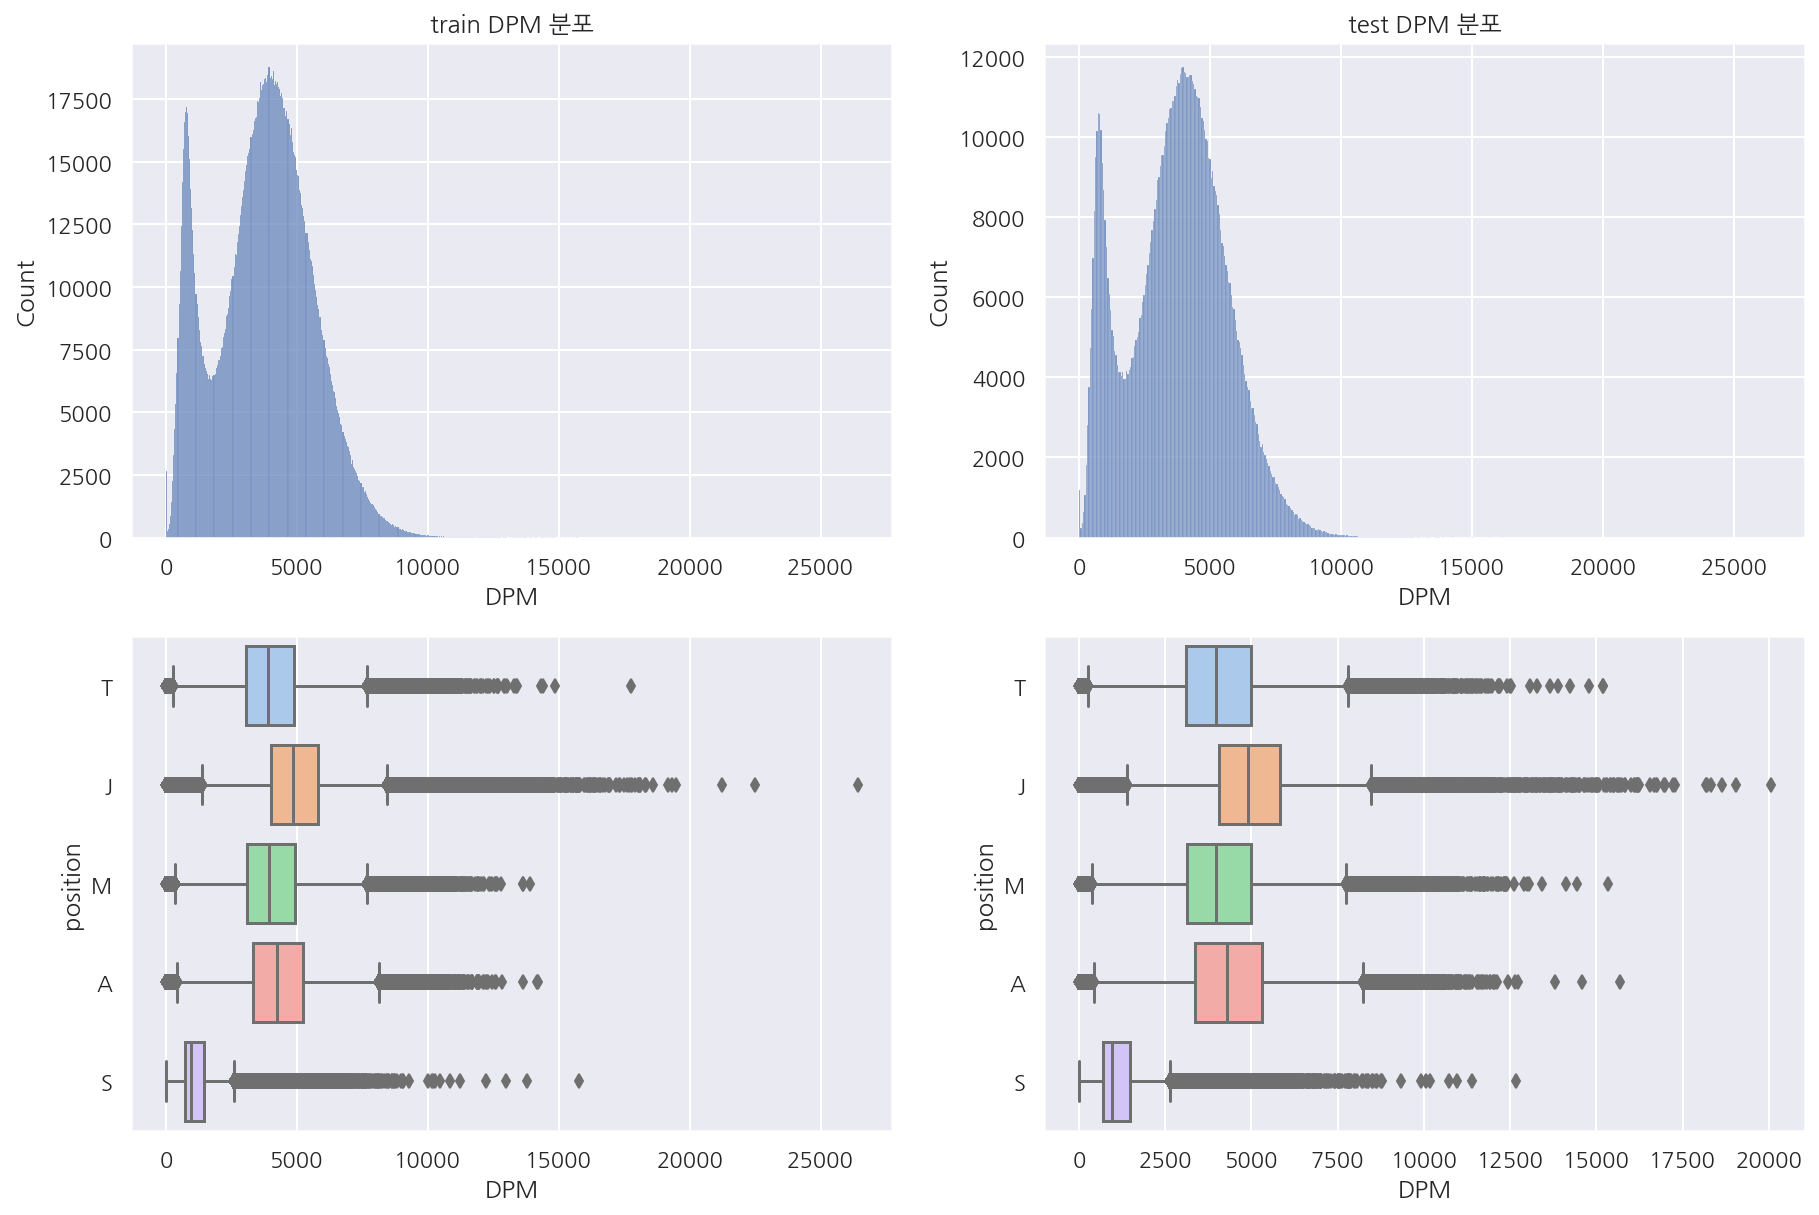

In [40]:
visualization("train", "test", "DPM")

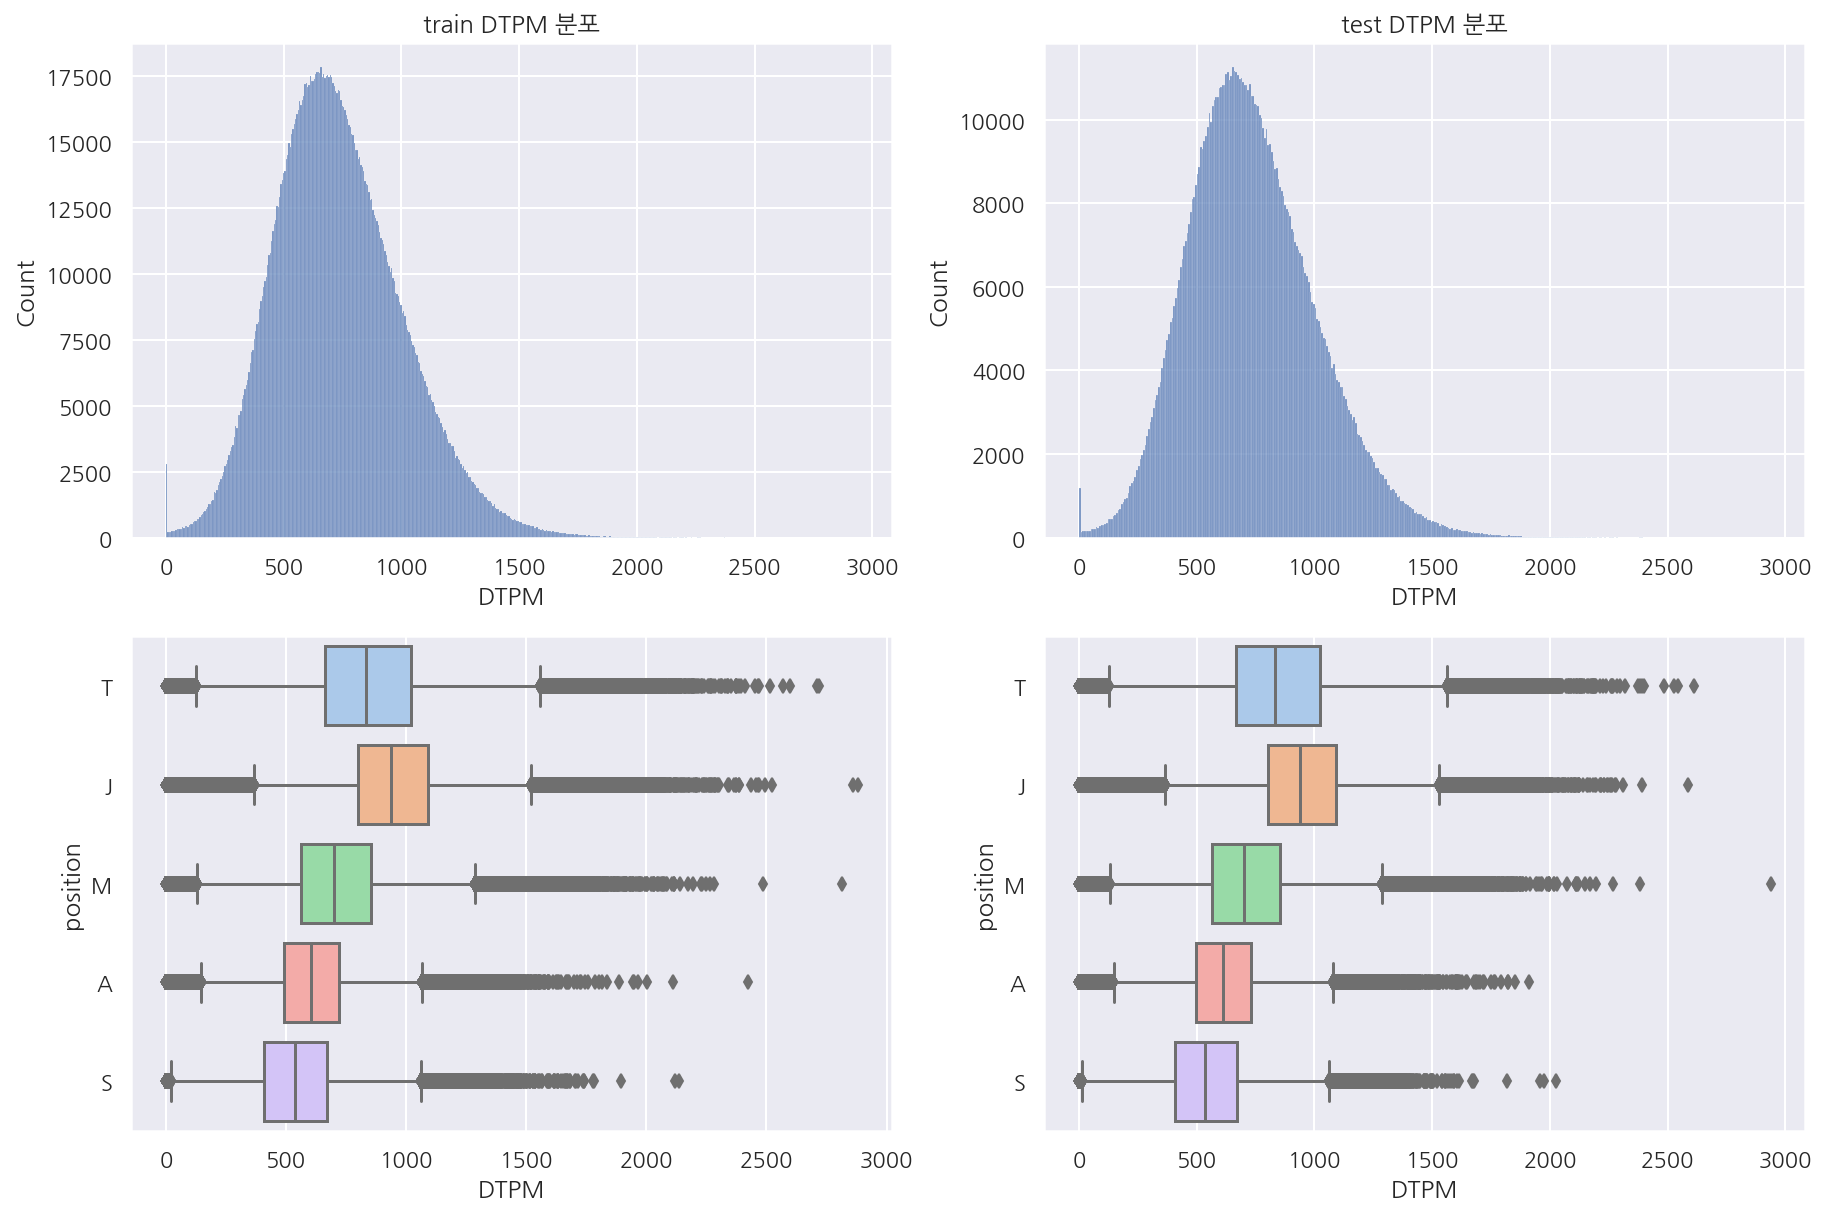

In [41]:
visualization("train", "test", "DTPM")

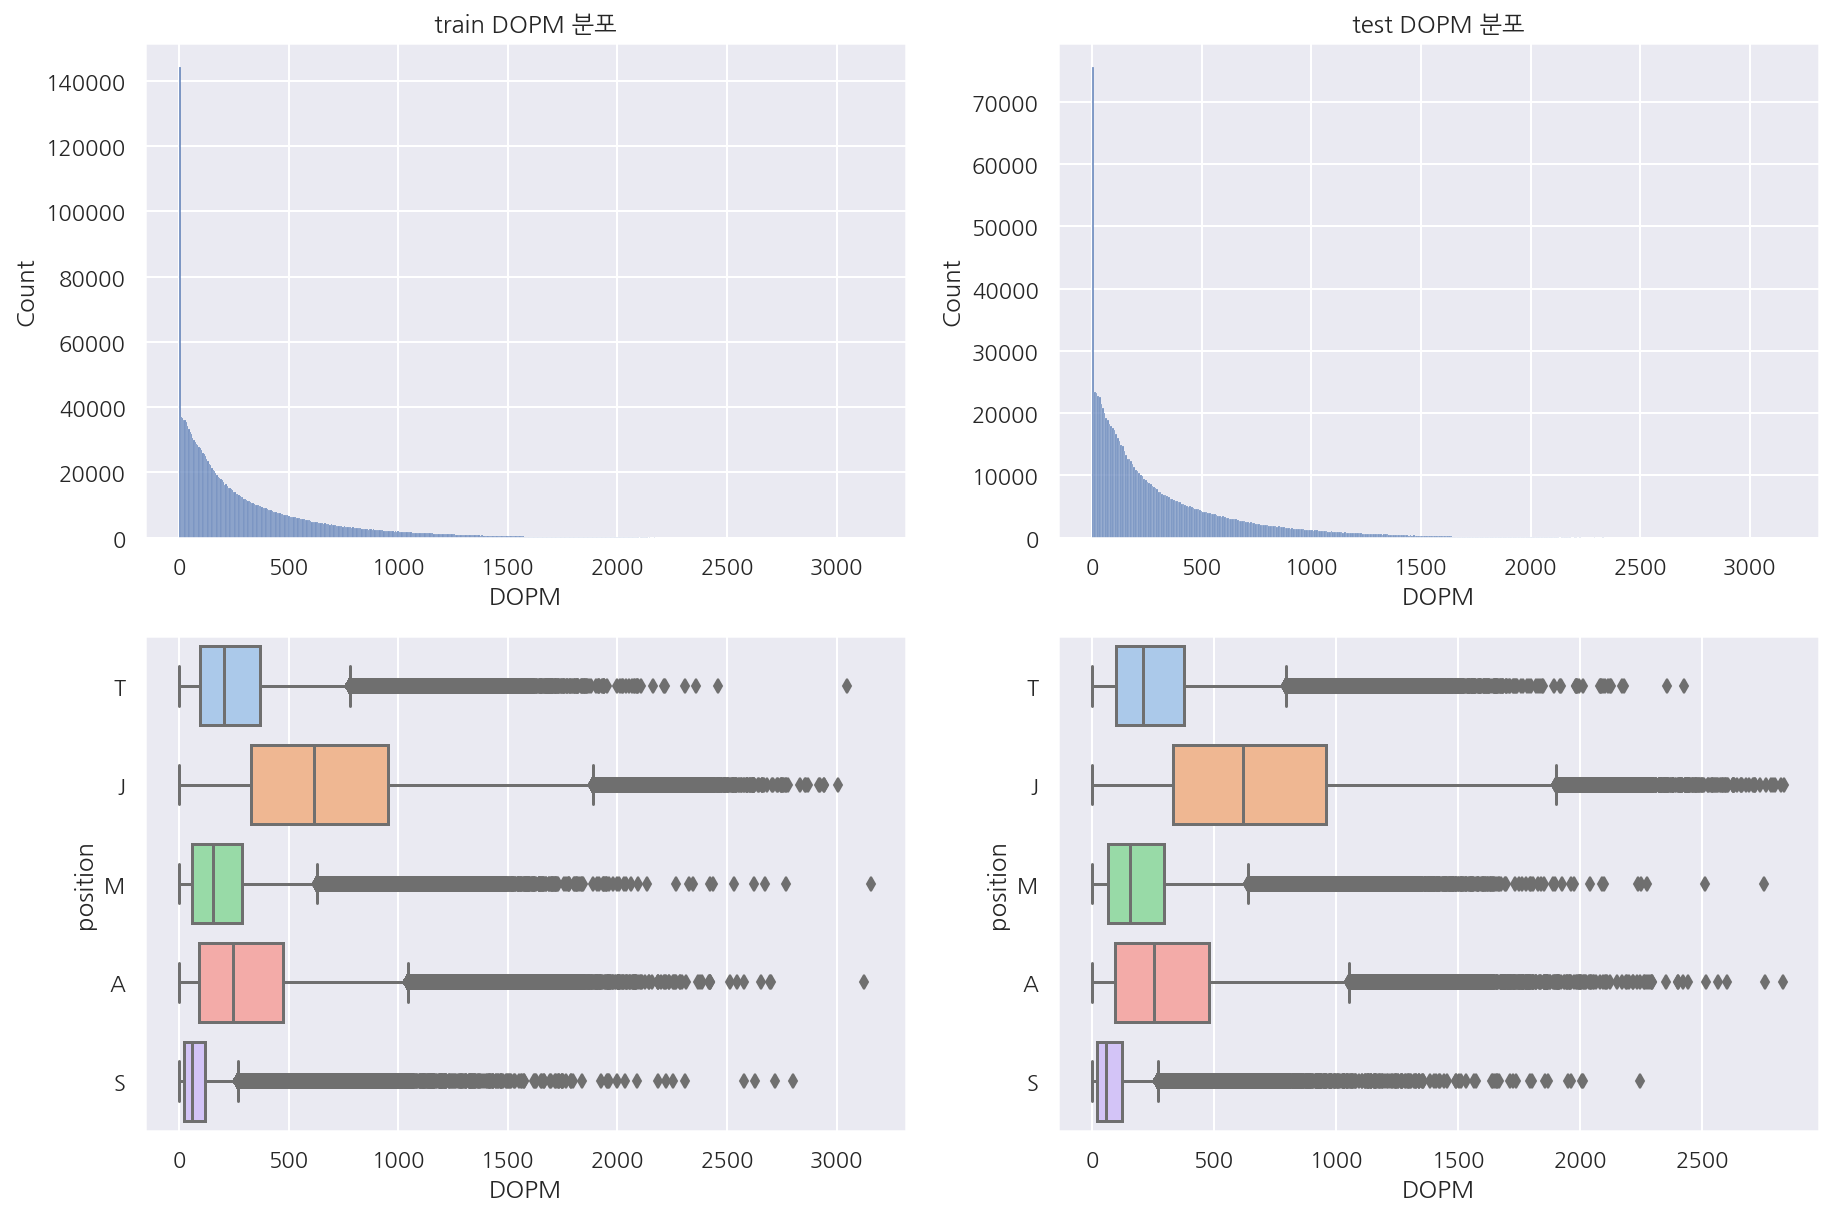

In [42]:
visualization("train", "test", "DOPM")